# GROUP MEMBERS

Paul Alexandru Radu Loghin, 1942544, raduloghin.1942544@studenti.uniroma1.it

Andrea Maggiore, 1947898, maggiore.1947898@studenti.uniroma1.it

# AML Homework 3: Practice


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques. 


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model. 
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F
import platform as pl


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [ ]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        
        nn.Linear(32, 10)
    )
    
    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [6]:
# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
images = np.stack([train_dataset[i][0] for i in range(len(train_dataset))])

# Compute the mean and standard deviation for each channel
mean = images.mean(axis=(0, 2, 3))
std = images.std(axis=(0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  [0.4914 0.4822 0.4465]
Std:  [0.247  0.2435 0.2616]


In [7]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),          # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)  

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [8]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

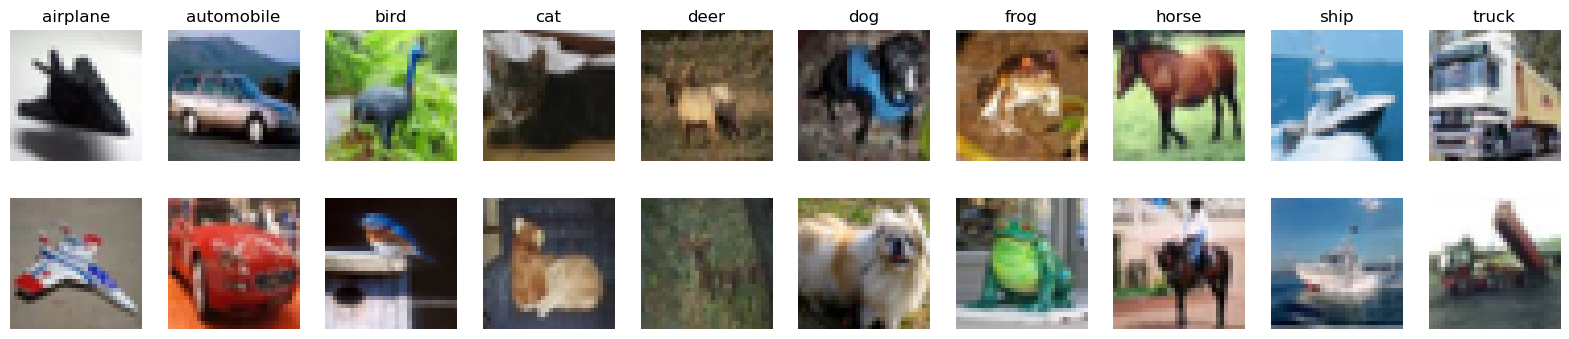

In [9]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')
    

### 1.4: Training Loop

In [10]:
# We had to add this check cause we are also using ARM systems
if pl.system() == "Darwin":
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load weights
model = create_model()
model.load_state_dict(torch.load('checkpoint/model_weights.pth', weights_only=True))  
model.to(device)

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler 
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")



Epoch [1/20]: 100%|██████████| 98/98 [00:11<00:00,  8.57it/s, loss=1.57]


Epoch [1/20], Average Loss: 1.8941
Validation Loss: 1.6080


Epoch [2/20]: 100%|██████████| 98/98 [00:10<00:00,  9.30it/s, loss=1.4] 


Epoch [2/20], Average Loss: 1.4628
Validation Loss: 1.3944


Epoch [3/20]: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s, loss=1.29]


Epoch [3/20], Average Loss: 1.3180
Validation Loss: 1.2050


Epoch [4/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.17]


Epoch [4/20], Average Loss: 1.2498
Validation Loss: 1.2114


Epoch [5/20]: 100%|██████████| 98/98 [00:10<00:00,  9.30it/s, loss=1.18]


Epoch [5/20], Average Loss: 1.1953
Validation Loss: 1.1738


Epoch [6/20]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.19]


Epoch [6/20], Average Loss: 1.1558
Validation Loss: 1.1309


Epoch [7/20]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.15]


Epoch [7/20], Average Loss: 1.1206
Validation Loss: 1.0289


Epoch [8/20]: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s, loss=1.05]


Epoch [8/20], Average Loss: 1.0961
Validation Loss: 1.0001


Epoch [9/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.09] 


Epoch [9/20], Average Loss: 1.0804
Validation Loss: 1.1155


Epoch [10/20]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.08] 


Epoch [10/20], Average Loss: 1.0586
Validation Loss: 1.0314


Epoch [11/20]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=0.981]


Epoch [11/20], Average Loss: 1.0358
Validation Loss: 0.9611


Epoch [12/20]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=0.91] 


Epoch [12/20], Average Loss: 1.0222
Validation Loss: 0.9391


Epoch [13/20]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.11] 


Epoch [13/20], Average Loss: 1.0024
Validation Loss: 1.0020


Epoch [14/20]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=1.01] 


Epoch [14/20], Average Loss: 0.9978
Validation Loss: 1.0183


Epoch [15/20]: 100%|██████████| 98/98 [00:10<00:00,  9.06it/s, loss=1]    


Epoch [15/20], Average Loss: 0.9728
Validation Loss: 0.8788


Epoch [16/20]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=0.886]


Epoch [16/20], Average Loss: 0.9601
Validation Loss: 0.9412


Epoch [17/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.07] 


Epoch [17/20], Average Loss: 0.9570
Validation Loss: 1.0149


Epoch [18/20]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=0.918]


Epoch [18/20], Average Loss: 0.9408
Validation Loss: 0.8788


Epoch [19/20]: 100%|██████████| 98/98 [00:10<00:00,  9.44it/s, loss=0.895]


Epoch [19/20], Average Loss: 0.9327
Validation Loss: 0.8700


Epoch [20/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=0.914]


Epoch [20/20], Average Loss: 0.9232
Validation Loss: 0.9369


Best validation loss: 0.8700


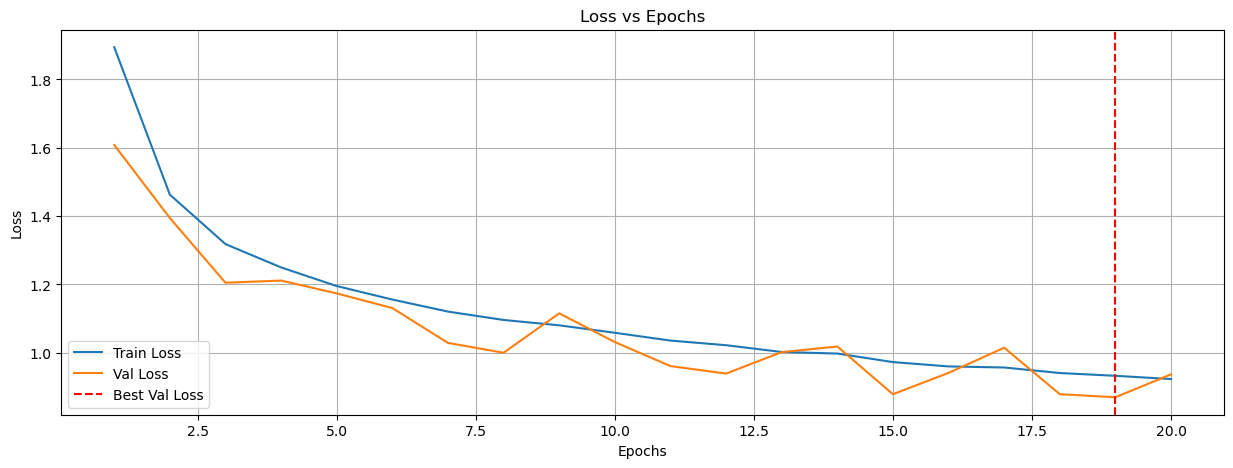

In [12]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A: it can be seen that:

1) *Loss oversizing* :  "Val Loss" oscillates and reach the minimum Loss at the 18 epoch. This could indicate that the model is starting to overfit to the training data, adapting too much to the specifich characteristics of the training set and losing its ability to generalize well on new data.

2) *Stability of Val Loss* : There is no constant variability in the Val Loss curve, that could mean:

    - The Branch Size is too small, that put high variance in the loss estimates. Increasing the batch size could stabilize the Val Loss curve

    - There a possibile noise inside the dataset

3) *Difference between train and Val Loss* : While the Train Loss has a constant decrease, the other (Val Loss) fluctuates. The Training and Val Loss should converge, but there's an increasing discrepancy.
     

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [13]:
# accuracy 
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [14]:
# your model 
model = create_model()
model.load_state_dict(torch.load('checkpoint/trained_model.pth', weights_only=True))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set 
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

Your Model Train Accuracy : 70.4780
Your Model Test Accuracy : 68.9500


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [15]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth",map_location="mps", weights_only=False))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

Train accuracy: 86.3800
Test Accuracy: 80.9000


# Section 2: Unlearning 

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario, 
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned. 

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning 

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data. 
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [16]:
#train
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in train_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset = torch.utils.data.Subset(train_dataset, indices_to_remember)
forget_dataset = torch.utils.data.Subset(train_dataset, indices_to_forget)
retain_loader = DataLoader(retain_dataset, batch_size)
forget_loader = DataLoader(forget_dataset, batch_size)

In [17]:
#validation
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in val_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset_val = torch.utils.data.Subset(val_dataset, indices_to_remember)
forget_dataset_val = torch.utils.data.Subset(val_dataset, indices_to_forget)
retain_loader_val = DataLoader(retain_dataset_val, batch_size)
forget_loader_val = DataLoader(forget_dataset_val, batch_size)

In [18]:
#test 
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in test_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset_test = torch.utils.data.Subset(test_dataset, indices_to_remember)
forget_dataset_test = torch.utils.data.Subset(test_dataset, indices_to_forget)
retain_loader_test = DataLoader(retain_dataset_test, batch_size)
forget_loader_test = DataLoader(forget_dataset_test, batch_size)

### 2.2: Training Loop

In [19]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    # We had to add this check cause we are also using ARM systems
    if pl.system() == "Darwin":
      device = torch.device("mps" if torch.mps.is_available() else "cpu")
    else:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []
   
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(retain_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in retain_loader_val:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
        
                
    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [20]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth", map_location="cpu", weights_only=False))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, val_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=0.471]


Epoch [1/10], Average Loss: 0.5236
Validation Loss: 0.5104


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.40it/s, loss=0.459]


Epoch [2/10], Average Loss: 0.5068
Validation Loss: 0.5119


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=0.441]


Epoch [3/10], Average Loss: 0.4968
Validation Loss: 0.5076


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.39it/s, loss=0.474]


Epoch [4/10], Average Loss: 0.4927
Validation Loss: 0.5003


Epoch [5/10]: 100%|██████████| 88/88 [00:09<00:00,  9.41it/s, loss=0.474]


Epoch [5/10], Average Loss: 0.4939
Validation Loss: 0.5063


Epoch [6/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=0.433]


Epoch [6/10], Average Loss: 0.4889
Validation Loss: 0.4992


Epoch [7/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=0.481]


Epoch [7/10], Average Loss: 0.4883
Validation Loss: 0.5025


Epoch [8/10]: 100%|██████████| 88/88 [00:09<00:00,  9.41it/s, loss=0.424]


Epoch [8/10], Average Loss: 0.4869
Validation Loss: 0.5047


Epoch [9/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=0.452]


Epoch [9/10], Average Loss: 0.4872
Validation Loss: 0.4998


Epoch [10/10]: 100%|██████████| 88/88 [00:09<00:00,  9.40it/s, loss=0.408]


Epoch [10/10], Average Loss: 0.4850
Validation Loss: 0.5039


/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/858582591.py:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/

**Below there is the evaluation of your unlearned by fine-tuning model**

In [21]:

# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
forget_model.eval()
forget_model.to(device)

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/3122407584.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("chec

Retain set Accuracy: 88.6711
Forget set Accuracy: 40.4600
Test set Accuracy: 77.9125
Test set Retain Accuracy: 82.9583
Test set Forget Accuracy: 32.5000


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A: 
The high accuracy on the retain set indicates that the model has preserved a good generalization ability on the data we are not trying to forget.
The relatively low accuracy on the forget set during training suggests that the unlearning process is working to some extent: the model has significantly reduced its ability to correctly predict the data we are trying to forget.
The accuracy on the test set indicates that the model is performing well despite unlearning the forget set. This shows that the process of forgetting certain data has not significantly degraded the model’s performance on the remaining data.
The model’s accuracy on the test set retain indicates that the model has successfully retained knowledge of the data we do not want it to forget. This means that the unlearning process has been effective in forgetting only the relevant data without significantly compromising the model's ability to generalize on the retained data.
The low accuracy on the test set forget is a positive sign for the unlearning process. Such a low accuracy suggests that the model has successfully forgotten most of the information related to the forget set, as it can no longer correctly classify those examples. This indicates that unlearning has been effective.

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [22]:
# We had to add this check cause we are also using ARM systems
if pl.system() == "Darwin":
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/810956610.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpo

#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [23]:

# Variabile per il miglior validation loss
best_loss = float('inf')

losses = []
losses_val = []

for epoch in range(num_epochs):
    gold_model.train()
    running_loss = 0
    
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = gold_model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        running_loss += loss.item()

        # Update progress bar
        loop.set_description(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m")
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    scheduler.step(avg_loss)
    print(f"Training loss: {avg_loss:.4f}")

    # Validation step
    gold_model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = gold_model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    losses_val.append(avg_val_loss)

    # Save best model based on validation loss
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        os.makedirs("checkpoint", exist_ok=True)
        torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        print("\033[92mBest model saved with validation loss: {:.4f}\033[0m".format(best_loss))


Epoch [1/20]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.17]


Training loss: 2.2336
Best model saved with validation loss: 2.1562


Epoch [2/20]: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s, loss=2]   


Training loss: 2.1097
Best model saved with validation loss: 2.0267


Epoch [3/20]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.89]


Training loss: 1.9774
Best model saved with validation loss: 1.8842


Epoch [4/20]: 100%|██████████| 98/98 [00:10<00:00,  9.41it/s, loss=1.79]


Training loss: 1.8455
Best model saved with validation loss: 1.7542


Epoch [5/20]: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s, loss=1.73]


Training loss: 1.7346
Best model saved with validation loss: 1.6416


Epoch [6/20]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=1.61]


Training loss: 1.6499
Best model saved with validation loss: 1.5572


Epoch [7/20]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.51]


Training loss: 1.5828
Best model saved with validation loss: 1.4959


Epoch [8/20]: 100%|██████████| 98/98 [00:10<00:00,  9.41it/s, loss=1.46]


Training loss: 1.5286
Best model saved with validation loss: 1.4343


Epoch [9/20]: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s, loss=1.45]


Training loss: 1.4781
Best model saved with validation loss: 1.3947


Epoch [10/20]: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s, loss=1.39]


Training loss: 1.4419
Best model saved with validation loss: 1.3417


Epoch [11/20]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.46]


Training loss: 1.4040
Best model saved with validation loss: 1.3131


Epoch [12/20]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.38]


Training loss: 1.3739
Best model saved with validation loss: 1.2816


Epoch [13/20]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.32]


Training loss: 1.3486
Best model saved with validation loss: 1.2535


Epoch [14/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.35]


Training loss: 1.3288
Best model saved with validation loss: 1.2435


Epoch [15/20]: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s, loss=1.29]


Training loss: 1.3072
Best model saved with validation loss: 1.2155


Epoch [16/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.37]


Training loss: 1.2913
Best model saved with validation loss: 1.1950


Epoch [17/20]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.14]


Training loss: 1.2746
Best model saved with validation loss: 1.1776


Epoch [18/20]: 100%|██████████| 98/98 [00:10<00:00,  9.41it/s, loss=1.37]


Training loss: 1.2633
Best model saved with validation loss: 1.1568


Epoch [19/20]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.25]


Training loss: 1.2465
Best model saved with validation loss: 1.1515


Epoch [20/20]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.33]


Training loss: 1.2371
Best model saved with validation loss: 1.1369


Best validation loss: 1.1369


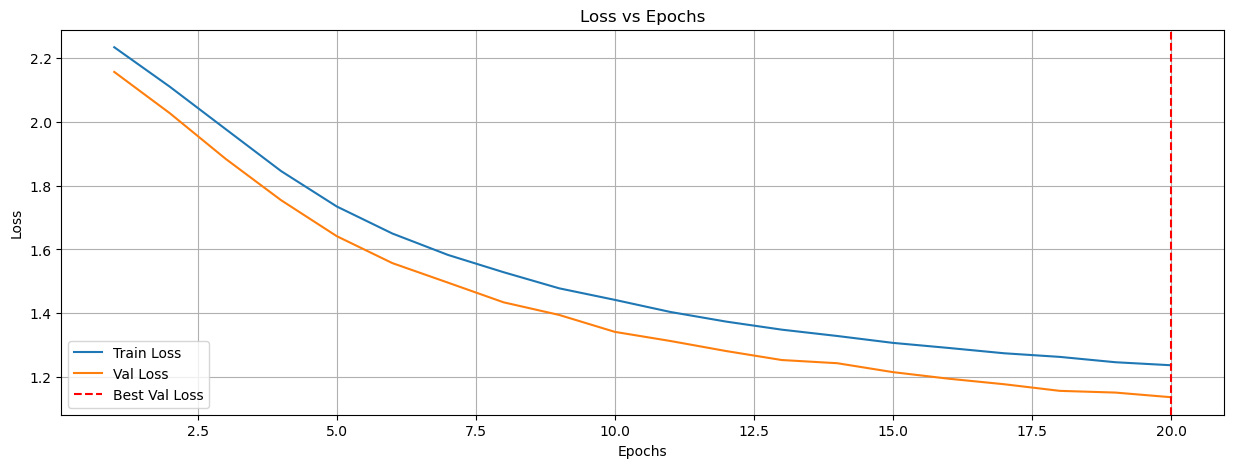

In [24]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [25]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device)

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/1336622808.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkp

Retain set Accuracy: 60.1511
Forget set Accuracy: 50.3200
Test set Accuracy: 58.1750
Test set Retain Accuracy: 59.2778
Test set Forget Accuracy: 48.2500


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: The Gold Model shows a constant improvement, with a less loss during the training and saving a checkpoint when it reaches its best perfomance.
After the checkpoint load, the model has an greater accuracy  on *retain* set than *forget*. This difference is expected, as the model is designed to keep the important information of the
*retain* set and selectively disregard that of the *forget* one.
In this way, it shows that it can effectively differentiate between the two types of data.

# Section 4: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [26]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """
    # We had to add this check cause we are also using ARM systems
    if pl.system() == "Darwin":
        device = torch.device("mps" if torch.mps.is_available() else "cpu")
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()
   
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


In [27]:
#model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth",map_location="mps"));
model.eval()
model.to(device)

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)


/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/451064410.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/b

In [28]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device)

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)


/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/3409819868.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("chec

In [29]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));
gold_model.eval()
gold_model.to(device)

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/1122610259.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkp

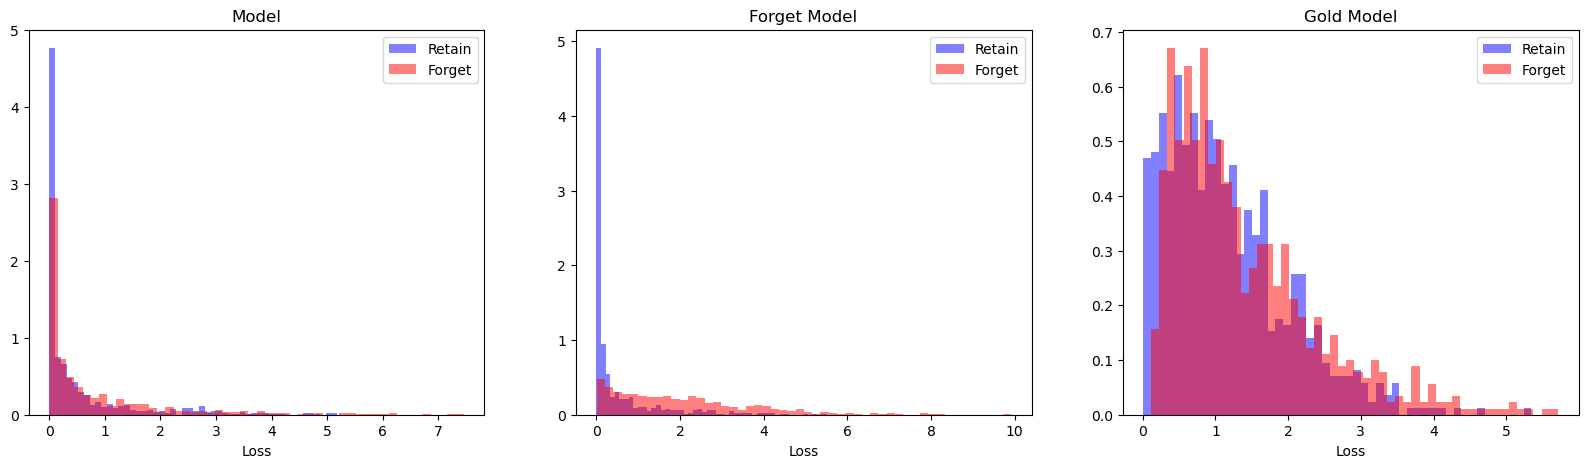

In [30]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [31]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """
    
    torch.manual_seed(torch.initial_seed())
    
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )
    
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy", 
    )

In [32]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5369


In [33]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.7469


In [34]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 0.5400


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A: 
- **Model**:
The loss distributions between the *Retain* and *Forget* samples are very similar, in the plots. 
That can be considered in a low MIA score, indicating that the model does not expose much information about whether the data was used for training. Therefore, it is difficult for the attacker to discriminate samples on the basis of membership.

- **Forget Model**:
The loss for the *Forget* samples are higher, andthe loss distributions between *Retain* and *Forget* are well separated.
This leads to a higher MIA score, suggesting that this model is vulnerable to MIA attack, as the attacker is bettere able to identify the sample belonging to the training set.

- **Gold Model**:
Losses are balanced between the *Retain* and *Forget* samples. This model has low MIA score, indicating that it is well generalised and withstands the MIA attack, thus protecting the training data.


# 5. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point) 

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: In this case, KL divergence is preferred over Cross-Entropy because it measures how much the predicted distribution deviates from the target (uniform) distribution. Since we want the model to forget by making its predictions match a uniform distribution, KL divergence directly quantifies the distance from this ideal distribution, while Cross-Entropy assumes a specific ground-truth class, which is not applicable here.

In [35]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])  
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''
cross_entropy = F.cross_entropy(y_pred.unsqueeze(0), y_gt.argmax().unsqueeze(0))
kl_div = F.kl_div(y_pred.log(), y_gt, reduction="sum")

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

A: 

**Cross-Entropy** measures the difference between two probability distributions for a given set of events outcomes. For two distributions (**P**) (true distribution) and (**Q**) (approx distribution), the cross-entropy is defined as:

$$ H(P, Q) = - \sum_x P(x) \log Q(x) $$


**Kullback-Leibler (KL)** Divergence, measures how one probability distribution diverges from a second, expected probability distribution. For distribution (**P**) and (**Q**), the KL is:

$$ D_{KL}(P \| Q) = \sum_x P(x) \log \frac{P(x)}{Q(x)} $$



**Relationship between Cross-Entropy and KL Divergence** can be derived as follows:

1. Start with the definition of KL Divergence and rewrite the logarithm term:

   $$ D_{KL}(P \| Q) = \sum_x P(x) \log P(x) - \sum_x P(x) \log Q(x) $$

2. Recognize that the first term is the negative entropy of (**P**):

   $$ H(P) = - \sum_x P(x) \log P(x) $$

   Therefore,

   $$ -H(P) = \sum_x P(x) \log P(x) $$

3. Substitute this into the KL Divergence equation:

   $$ D_{KL}(P \| Q) = -H(P) + \sum_x P(x) \log Q(x) $$

4. Notice that the second term is the negative cross-entropy:

   $$ H(P, Q) = - \sum_x P(x) \log Q(x) $$

   Therefore

   $$ -H(P, Q) = \sum_x P(x) \log Q(x) $$

5. Combine these results:

   $$ D_{KL}(P \| Q) = -H(P) - H(P, Q) $$

   Rearranging gives us:

   $$ H(P, Q) = H(P) + D_{KL}(P \| Q) $$

The cross-entropy (**H(P, Q)**) between two distributions (**P**) and (**Q**) is equal to the entropy (**H(P)**) of the true distribution plus the KL divergence (D_{KL}**(P | Q)**) between the true distribution and the approximate distribution. This relationship shows that cross-entropy includes both the inherent uncertainty in the true distribution and the additional uncertainty due to the approximation.



In [36]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [37]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0
    
    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [38]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []
    
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)
            
            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [39]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth", map_location="mps"));
another_forget_model.to(device)

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/4001366752.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.lo

Epoch [1/10], Average Loss: 1.6896
Validation Loss: 1.4908


Epoch [2/10]: 100%|██████████| 10/10 [00:04<00:00,  2.48it/s, loss=1.17]


Epoch [2/10], Average Loss: 1.2911
Validation Loss: 1.0747


Epoch [3/10]: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s, loss=0.965]


Epoch [3/10], Average Loss: 1.0523
Validation Loss: 0.8575


Epoch [4/10]: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s, loss=0.792]


Epoch [4/10], Average Loss: 0.8671
Validation Loss: 0.7207


Epoch [5/10]: 100%|██████████| 10/10 [00:04<00:00,  2.45it/s, loss=0.697]


Epoch [5/10], Average Loss: 0.7436
Validation Loss: 0.6196


Epoch [6/10]: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s, loss=0.605]


Epoch [6/10], Average Loss: 0.6489
Validation Loss: 0.5389


Epoch [7/10]: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s, loss=0.523]


Epoch [7/10], Average Loss: 0.5715
Validation Loss: 0.4747


Epoch [8/10]: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s, loss=0.48]


Epoch [8/10], Average Loss: 0.5072
Validation Loss: 0.4288


Epoch [9/10]: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s, loss=0.413]


Epoch [9/10], Average Loss: 0.4589
Validation Loss: 0.3857


Epoch [10/10]: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s, loss=0.402]

Epoch [10/10], Average Loss: 0.4118
Validation Loss: 0.3432


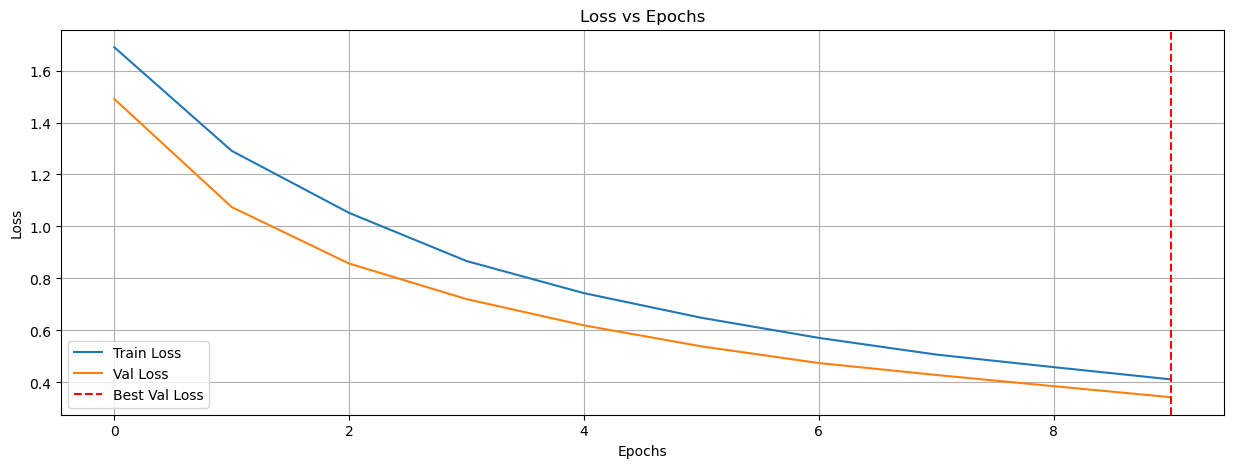

In [40]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [41]:
# calculate accuracy 
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/2802900956.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.lo

In [42]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 64.0400
Forget Accuracy: 16.6200
Test Accuracy: 56.5625
Test Retain Accuracy: 61.2222
Test Forget Accuracy: 14.6250


In [43]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

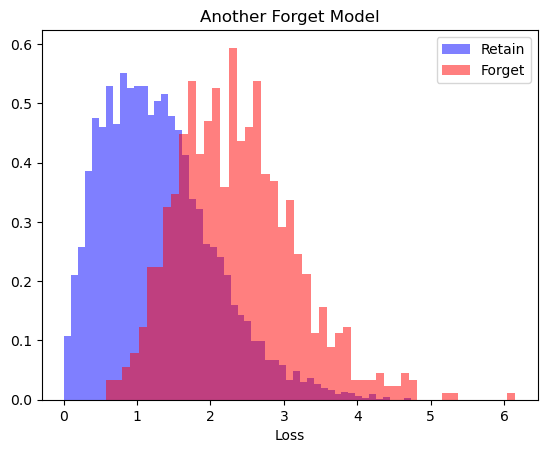

In [44]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [45]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

Another Forget Model MIA score with Cross Entropy losses: 0.7625


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

# GMN Dataset Building

Now we are gonna create a small CNN, we'll train it and then we will convert it into a graph.

For the CNNs we'll use the same structure defined in the first section of this notebook.

In [2]:

def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        
        nn.Linear(32, 10)
    )
    
    return model

In [3]:
# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''
images = np.stack([train_dataset[i][0] for i in range(len(train_dataset))])

# Compute the mean and standard deviation for each channel
mean = images.mean(axis=(0, 2, 3))
std = images.std(axis=(0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std),          # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)  

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

Files already downloaded and verified
Mean:  [0.4914 0.4822 0.4465]
Std:  [0.247  0.2435 0.2616]
Files already downloaded and verified
Files already downloaded and verified


In [4]:
# We had to add this check cause we are also using ARM systems
if pl.system() == "Darwin":
    device = torch.device("mps" if torch.mps.is_available() else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load weights
models = []
for _ in range(128):
    model = create_model()
    model.load_state_dict(torch.load('checkpoint/model_weights.pth', weights_only=True))  
    model.to(device)
    models.append(model)

# initialize the loss function
criterion = nn.CrossEntropyLoss()


In [50]:
import random

count = 0

for model in models:
    # define random optimizers for training
    optimizers = optimizers = [
    torch.optim.Adam(model.parameters(), lr=0.001),
    torch.optim.Adam(model.parameters(), lr=0.005),
    torch.optim.Adam(model.parameters(), lr=0.0001),
    torch.optim.SGD(model.parameters(), lr=0.001),
    torch.optim.RMSprop(model.parameters(), lr=0.001)
]
    
    optimizer = random.choice(optimizers)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
    num_epochs = random.randint(1, 4)

    # Placeholder for storing losses for each epoch
    losses = []
    losses_val = []

    # Training the model
    for epoch in range(num_epochs):

        ######### TRAINING ##########
        model.train()
        running_loss = 0  # To track loss for this epoch

        # Using tqdm for the progress bar
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    
        
        for batch_idx, (data, targets) in loop:
            # Get data to cuda if possible
            data = data.to(device=device)
            targets = targets.to(device=device)

            # Forward pass
            scores = model(data)
            loss = criterion(scores, targets)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Gradient descent step
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()

            # Update progress bar with loss and epoch information
            loop.set_description(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m")
            loop.set_postfix(loss=loss.item())

        # Calculate average loss for the epoch
        avg_loss = running_loss / len(train_loader)
        losses.append(avg_loss)

        #scheduler 
        scheduler.step(avg_loss)

        # Print loss for this epoch
        tqdm.write(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m, Average Loss: {avg_loss:.4f}")

        ####### VALIDATION ########
        model.eval()
        val_loss = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                val_loss += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = val_loss / len(val_loader)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint/gmn_dataset", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/gmn_dataset/trained_model_"+str(count)+".pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/gmn_dataset/trained_model"+str(count)+".pth")
    count += 1



/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s, loss=2.3] 


Epoch [1/4], Average Loss: 2.3077
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.3] 


Epoch [2/4], Average Loss: 2.3040
Validation Loss: 2.2991


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s, loss=2.3] 


Epoch [3/4], Average Loss: 2.3007
Validation Loss: 2.2958


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.29]


Epoch [4/4], Average Loss: 2.2973
Validation Loss: 2.2926


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.58]


Epoch [1/3], Average Loss: 1.8889
Validation Loss: 1.5668


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.4] 


Epoch [2/3], Average Loss: 1.4518
Validation Loss: 1.3867


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.35]


Epoch [3/3], Average Loss: 1.3176
Validation Loss: 1.3316


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.58]


Epoch [1/4], Average Loss: 1.7488
Validation Loss: 1.6442


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.42]


Epoch [2/4], Average Loss: 1.4780
Validation Loss: 1.3933


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.32]


Epoch [3/4], Average Loss: 1.3715
Validation Loss: 1.5135


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.28]


Epoch [4/4], Average Loss: 1.3055
Validation Loss: 1.5037


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=2.3] 


Epoch [1/3], Average Loss: 2.3077
Validation Loss: 2.3025


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=2.3] 


Epoch [2/3], Average Loss: 2.3040
Validation Loss: 2.2991


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.29]


Epoch [3/3], Average Loss: 2.3010
Validation Loss: 2.2958


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s, loss=2.31]


Epoch [1/3], Average Loss: 2.3074
Validation Loss: 2.3025


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.3] 


Epoch [2/3], Average Loss: 2.3040
Validation Loss: 2.2990


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.27it/s, loss=2.28]


Epoch [3/3], Average Loss: 2.3007
Validation Loss: 2.2958


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s, loss=1.57]


Epoch [1/2], Average Loss: 1.7629
Validation Loss: 1.6322


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.43]


Epoch [2/2], Average Loss: 1.4889
Validation Loss: 1.5282


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.61]


Epoch [1/2], Average Loss: 1.7587
Validation Loss: 1.7602


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=1.34]


Epoch [2/2], Average Loss: 1.4831
Validation Loss: 1.4205


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=2.19]


Epoch [1/2], Average Loss: 2.2333
Validation Loss: 2.1609


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.07]


Epoch [2/2], Average Loss: 2.1048
Validation Loss: 2.0349


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.53]


Epoch [1/3], Average Loss: 1.8866
Validation Loss: 1.5913


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.5] 


Epoch [2/3], Average Loss: 1.4659
Validation Loss: 1.4026


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.28]


Epoch [3/3], Average Loss: 1.3247
Validation Loss: 1.2644


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.61]


Epoch [1/2], Average Loss: 1.7567
Validation Loss: 1.7139


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=1.47]


Epoch [2/2], Average Loss: 1.4833
Validation Loss: 1.5306


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s, loss=2.16]


Epoch [1/1], Average Loss: 2.2331
Validation Loss: 2.1597


Epoch [1/3]: 100%|██████████| 98/98 [00:11<00:00,  8.90it/s, loss=1.57]


Epoch [1/3], Average Loss: 1.8921
Validation Loss: 1.5746


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.29it/s, loss=1.33]


Epoch [2/3], Average Loss: 1.4639
Validation Loss: 1.3454


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.29it/s, loss=1.28]


Epoch [3/3], Average Loss: 1.3231
Validation Loss: 1.3059


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s, loss=2.29]


Epoch [1/1], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s, loss=2.16]


Epoch [1/4], Average Loss: 2.2353
Validation Loss: 2.1637


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=2.05]


Epoch [2/4], Average Loss: 2.1074
Validation Loss: 2.0379


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.96]


Epoch [3/4], Average Loss: 1.9721
Validation Loss: 1.8967


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.79]


Epoch [4/4], Average Loss: 1.8427
Validation Loss: 1.7726


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.19]


Epoch [1/2], Average Loss: 2.2338
Validation Loss: 2.1663


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s, loss=2.03]


Epoch [2/2], Average Loss: 2.1078
Validation Loss: 2.0374


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.62]


Epoch [1/4], Average Loss: 1.7595
Validation Loss: 1.6133


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.47]


Epoch [2/4], Average Loss: 1.4859
Validation Loss: 1.4481


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.4] 


Epoch [3/4], Average Loss: 1.3809
Validation Loss: 1.4312


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.2] 


Epoch [4/4], Average Loss: 1.3091
Validation Loss: 1.3937


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s, loss=2.31]


Epoch [1/3], Average Loss: 2.3077
Validation Loss: 2.3025


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.02it/s, loss=2.3] 


Epoch [2/3], Average Loss: 2.3043
Validation Loss: 2.2992


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s, loss=2.3] 


Epoch [3/3], Average Loss: 2.3008
Validation Loss: 2.2958


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.55]


Epoch [1/1], Average Loss: 1.8893
Validation Loss: 1.5938


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.61]


Epoch [1/4], Average Loss: 1.8834
Validation Loss: 1.5820


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.4] 


Epoch [2/4], Average Loss: 1.4664
Validation Loss: 1.5208


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.22]


Epoch [3/4], Average Loss: 1.3246
Validation Loss: 1.2846


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=1.19]


Epoch [4/4], Average Loss: 1.2442
Validation Loss: 1.2415


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.20it/s, loss=1.62]


Epoch [1/4], Average Loss: 1.8932
Validation Loss: 1.5883


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=1.39]


Epoch [2/4], Average Loss: 1.4739
Validation Loss: 1.3740


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.38]


Epoch [3/4], Average Loss: 1.3299
Validation Loss: 1.3875


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.21]


Epoch [4/4], Average Loss: 1.2578
Validation Loss: 1.2224


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=2.19]


Epoch [1/2], Average Loss: 2.2336
Validation Loss: 2.1600


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.02]


Epoch [2/2], Average Loss: 2.1034
Validation Loss: 2.0321


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=2.16]


Epoch [1/1], Average Loss: 2.2332
Validation Loss: 2.1606


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.42]


Epoch [1/2], Average Loss: 1.6867
Validation Loss: 1.8194


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.32]


Epoch [2/2], Average Loss: 1.3710
Validation Loss: 1.2933


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.43]


Epoch [1/2], Average Loss: 1.7026
Validation Loss: 1.4931


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.27]


Epoch [2/2], Average Loss: 1.3579
Validation Loss: 1.4527


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.58]


Epoch [1/4], Average Loss: 1.7578
Validation Loss: 1.6233


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.46]


Epoch [2/4], Average Loss: 1.4786
Validation Loss: 1.4269


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.35]


Epoch [3/4], Average Loss: 1.3716
Validation Loss: 1.4476


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.33]


Epoch [4/4], Average Loss: 1.3053
Validation Loss: 1.5011


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.57]


Epoch [1/1], Average Loss: 1.8854
Validation Loss: 1.5948


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=2.18]


Epoch [1/4], Average Loss: 2.2343
Validation Loss: 2.1628


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.99]


Epoch [2/4], Average Loss: 2.1040
Validation Loss: 2.0342


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=1.94]


Epoch [3/4], Average Loss: 1.9714
Validation Loss: 1.9016


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.77]


Epoch [4/4], Average Loss: 1.8476
Validation Loss: 1.7869


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.5] 


Epoch [1/3], Average Loss: 1.8903
Validation Loss: 1.5648


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.47]


Epoch [2/3], Average Loss: 1.4561
Validation Loss: 1.4862


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.30it/s, loss=1.35]


Epoch [3/3], Average Loss: 1.3253
Validation Loss: 1.2369


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.03it/s, loss=1.51]


Epoch [1/3], Average Loss: 1.7534
Validation Loss: 1.5595


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s, loss=1.45]


Epoch [2/3], Average Loss: 1.4812
Validation Loss: 1.4425


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s, loss=1.34]


Epoch [3/3], Average Loss: 1.3755
Validation Loss: 1.3505


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.58]


Epoch [1/3], Average Loss: 1.8951
Validation Loss: 1.6038


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.39]


Epoch [2/3], Average Loss: 1.4576
Validation Loss: 1.3856


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.20it/s, loss=1.39]


Epoch [3/3], Average Loss: 1.3126
Validation Loss: 1.2681


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.53]


Epoch [1/2], Average Loss: 1.7453
Validation Loss: 1.6148


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.35]


Epoch [2/2], Average Loss: 1.4648
Validation Loss: 1.5973


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.61]


Epoch [1/3], Average Loss: 1.7614
Validation Loss: 1.8324


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.45]


Epoch [2/3], Average Loss: 1.4699
Validation Loss: 1.8353


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.33]


Epoch [3/3], Average Loss: 1.3724
Validation Loss: 1.3263


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.28]


Epoch [1/1], Average Loss: 2.3072
Validation Loss: 2.3025


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.57]


Epoch [1/4], Average Loss: 1.7571
Validation Loss: 1.6421


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.42]


Epoch [2/4], Average Loss: 1.4900
Validation Loss: 1.5331


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s, loss=1.33]


Epoch [3/4], Average Loss: 1.3868
Validation Loss: 1.3439


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  8.94it/s, loss=1.41]


Epoch [4/4], Average Loss: 1.3180
Validation Loss: 1.5711


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s, loss=2.18]


Epoch [1/2], Average Loss: 2.2345
Validation Loss: 2.1619


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.03]


Epoch [2/2], Average Loss: 2.1053
Validation Loss: 2.0365


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.18]


Epoch [1/2], Average Loss: 2.2339
Validation Loss: 2.1611


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.29it/s, loss=2.01]


Epoch [2/2], Average Loss: 2.1042
Validation Loss: 2.0340


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.49]


Epoch [1/2], Average Loss: 1.6980
Validation Loss: 1.5249


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.32]


Epoch [2/2], Average Loss: 1.3694
Validation Loss: 1.3920


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.65]


Epoch [1/3], Average Loss: 1.9006
Validation Loss: 1.5953


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.27it/s, loss=1.35]


Epoch [2/3], Average Loss: 1.4677
Validation Loss: 1.3547


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.35]


Epoch [3/3], Average Loss: 1.3140
Validation Loss: 1.3088


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.28it/s, loss=2.31]


Epoch [1/1], Average Loss: 2.3077
Validation Loss: 2.3025


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s, loss=1.65]


Epoch [1/2], Average Loss: 1.8988
Validation Loss: 1.6635


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.46]


Epoch [2/2], Average Loss: 1.4793
Validation Loss: 1.3853


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.5] 


Epoch [1/1], Average Loss: 1.7131
Validation Loss: 1.4744


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.54]


Epoch [1/4], Average Loss: 1.9000
Validation Loss: 1.5842


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.45]


Epoch [2/4], Average Loss: 1.4695
Validation Loss: 1.4494


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.29]


Epoch [3/4], Average Loss: 1.3266
Validation Loss: 1.2653


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.06]


Epoch [4/4], Average Loss: 1.2430
Validation Loss: 1.3632


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=1.58]


Epoch [1/3], Average Loss: 1.7515
Validation Loss: 1.5966


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s, loss=1.42]


Epoch [2/3], Average Loss: 1.4740
Validation Loss: 1.4656


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s, loss=1.32]


Epoch [3/3], Average Loss: 1.3730
Validation Loss: 1.4336


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.13it/s, loss=1.52]


Epoch [1/2], Average Loss: 1.7534
Validation Loss: 1.6195


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.42]


Epoch [2/2], Average Loss: 1.4834
Validation Loss: 1.5045


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.42]


Epoch [1/4], Average Loss: 1.6924
Validation Loss: 1.6807


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.41]


Epoch [2/4], Average Loss: 1.3639
Validation Loss: 1.2859


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.18]


Epoch [3/4], Average Loss: 1.2322
Validation Loss: 1.2418


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.22]


Epoch [4/4], Average Loss: 1.1644
Validation Loss: 1.2469


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=1.5] 


Epoch [1/3], Average Loss: 1.7497
Validation Loss: 1.6559


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.46]


Epoch [2/3], Average Loss: 1.4712
Validation Loss: 1.4013


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.34]


Epoch [3/3], Average Loss: 1.3645
Validation Loss: 1.4836


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.25it/s, loss=2.3] 


Epoch [1/4], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.27it/s, loss=2.3] 


Epoch [2/4], Average Loss: 2.3039
Validation Loss: 2.2991


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.07it/s, loss=2.3] 


Epoch [3/4], Average Loss: 2.3010
Validation Loss: 2.2959


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=2.29]


Epoch [4/4], Average Loss: 2.2974
Validation Loss: 2.2926


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.15]


Epoch [1/1], Average Loss: 2.2332
Validation Loss: 2.1603


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.16]


Epoch [1/1], Average Loss: 2.2334
Validation Loss: 2.1647


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.29it/s, loss=2.3] 


Epoch [1/3], Average Loss: 2.3076
Validation Loss: 2.3025


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.3] 


Epoch [2/3], Average Loss: 2.3042
Validation Loss: 2.2991


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=2.29]


Epoch [3/3], Average Loss: 2.3007
Validation Loss: 2.2958


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.51]


Epoch [1/2], Average Loss: 1.6892
Validation Loss: 1.5175


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.3] 


Epoch [2/2], Average Loss: 1.3721
Validation Loss: 1.5081


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.59]


Epoch [1/3], Average Loss: 1.8926
Validation Loss: 1.6358


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s, loss=1.35]


Epoch [2/3], Average Loss: 1.4751
Validation Loss: 1.4225


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.19]


Epoch [3/3], Average Loss: 1.3229
Validation Loss: 1.2779


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.62]


Epoch [1/2], Average Loss: 1.8868
Validation Loss: 1.6622


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.42]


Epoch [2/2], Average Loss: 1.4675
Validation Loss: 1.3764


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.17]


Epoch [1/2], Average Loss: 2.2337
Validation Loss: 2.1648


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=2.03]


Epoch [2/2], Average Loss: 2.1096
Validation Loss: 2.0377


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.15]


Epoch [1/4], Average Loss: 2.2337
Validation Loss: 2.1639


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=2.02]


Epoch [2/4], Average Loss: 2.1069
Validation Loss: 2.0322


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.89]


Epoch [3/4], Average Loss: 1.9682
Validation Loss: 1.9011


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.76]


Epoch [4/4], Average Loss: 1.8406
Validation Loss: 1.7786


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.20it/s, loss=1.58]


Epoch [1/1], Average Loss: 1.8875
Validation Loss: 1.6244


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.54]


Epoch [1/2], Average Loss: 1.7054
Validation Loss: 1.4769


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.27]


Epoch [2/2], Average Loss: 1.3609
Validation Loss: 1.3060


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.57]


Epoch [1/1], Average Loss: 1.8948
Validation Loss: 1.6137


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s, loss=1.55]


Epoch [1/1], Average Loss: 1.8876
Validation Loss: 1.6073


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s, loss=1.42]


Epoch [1/1], Average Loss: 1.7105
Validation Loss: 1.5877


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.29]


Epoch [1/1], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=2.18]


Epoch [1/1], Average Loss: 2.2339
Validation Loss: 2.1638


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.52]


Epoch [1/1], Average Loss: 1.8989
Validation Loss: 1.5830


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.43]


Epoch [1/2], Average Loss: 1.6925
Validation Loss: 1.4655


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s, loss=1.3] 


Epoch [2/2], Average Loss: 1.3571
Validation Loss: 1.3141


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.11it/s, loss=1.58]


Epoch [1/4], Average Loss: 1.8928
Validation Loss: 1.5960


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.37]


Epoch [2/4], Average Loss: 1.4647
Validation Loss: 1.3839


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.23]


Epoch [3/4], Average Loss: 1.3133
Validation Loss: 1.2729


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.26]


Epoch [4/4], Average Loss: 1.2411
Validation Loss: 1.2823


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.29it/s, loss=1.54]


Epoch [1/1], Average Loss: 1.6865
Validation Loss: 1.4964


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.59]


Epoch [1/4], Average Loss: 1.8906
Validation Loss: 1.5758


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.31]


Epoch [2/4], Average Loss: 1.4748
Validation Loss: 1.4164


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.28]


Epoch [3/4], Average Loss: 1.3269
Validation Loss: 1.3627


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.28]


Epoch [4/4], Average Loss: 1.2527
Validation Loss: 1.2529


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.54]


Epoch [1/1], Average Loss: 1.7480
Validation Loss: 1.5835


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s, loss=2.17]


Epoch [1/1], Average Loss: 2.2337
Validation Loss: 2.1620


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.46]


Epoch [1/1], Average Loss: 1.7070
Validation Loss: 1.6256


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.19]


Epoch [1/3], Average Loss: 2.2335
Validation Loss: 2.1625


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.04]


Epoch [2/3], Average Loss: 2.1063
Validation Loss: 2.0379


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.94]


Epoch [3/3], Average Loss: 1.9717
Validation Loss: 1.8988


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.31]


Epoch [1/2], Average Loss: 2.3074
Validation Loss: 2.3026


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.3] 


Epoch [2/2], Average Loss: 2.3041
Validation Loss: 2.2991


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.5] 


Epoch [1/4], Average Loss: 1.8759
Validation Loss: 1.5800


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.4] 


Epoch [2/4], Average Loss: 1.4499
Validation Loss: 1.3547


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.25]


Epoch [3/4], Average Loss: 1.3149
Validation Loss: 1.2432


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s, loss=1.31]


Epoch [4/4], Average Loss: 1.2402
Validation Loss: 1.1996


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.54]


Epoch [1/1], Average Loss: 1.8865
Validation Loss: 1.5886


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.27it/s, loss=2.3] 


Epoch [1/2], Average Loss: 2.3075
Validation Loss: 2.3025


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s, loss=2.31]


Epoch [2/2], Average Loss: 2.3040
Validation Loss: 2.2991


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=2.18]


Epoch [1/3], Average Loss: 2.2334
Validation Loss: 2.1653


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.07]


Epoch [2/3], Average Loss: 2.1083
Validation Loss: 2.0375


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.9] 


Epoch [3/3], Average Loss: 1.9727
Validation Loss: 1.9033


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.3] 


Epoch [1/2], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.29it/s, loss=2.3] 


Epoch [2/2], Average Loss: 2.3039
Validation Loss: 2.2991


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.54]


Epoch [1/1], Average Loss: 1.6785
Validation Loss: 1.5034


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.56]


Epoch [1/2], Average Loss: 1.6938
Validation Loss: 1.5135


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s, loss=1.28]


Epoch [2/2], Average Loss: 1.3815
Validation Loss: 1.5212


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=2.16]


Epoch [1/3], Average Loss: 2.2351
Validation Loss: 2.1669


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=2.02]


Epoch [2/3], Average Loss: 2.1064
Validation Loss: 2.0366


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.92]


Epoch [3/3], Average Loss: 1.9710
Validation Loss: 1.8977


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.55]


Epoch [1/4], Average Loss: 1.9020
Validation Loss: 1.5713


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.29]


Epoch [2/4], Average Loss: 1.4625
Validation Loss: 1.3996


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.22]


Epoch [3/4], Average Loss: 1.3246
Validation Loss: 1.3163


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.15]


Epoch [4/4], Average Loss: 1.2413
Validation Loss: 1.2099


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.44]


Epoch [1/1], Average Loss: 1.6858
Validation Loss: 1.4867


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.3] 


Epoch [1/4], Average Loss: 2.3074
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s, loss=2.3] 


Epoch [2/4], Average Loss: 2.3037
Validation Loss: 2.2991


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=2.31]


Epoch [3/4], Average Loss: 2.3009
Validation Loss: 2.2958


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.28]


Epoch [4/4], Average Loss: 2.2973
Validation Loss: 2.2926


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.56]


Epoch [1/3], Average Loss: 1.7370
Validation Loss: 1.6403


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.39]


Epoch [2/3], Average Loss: 1.4627
Validation Loss: 1.7237


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=1.38]


Epoch [3/3], Average Loss: 1.3713
Validation Loss: 1.4272


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=2.16]


Epoch [1/4], Average Loss: 2.2347
Validation Loss: 2.1643


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.05]


Epoch [2/4], Average Loss: 2.1100
Validation Loss: 2.0404


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.9] 


Epoch [3/4], Average Loss: 1.9760
Validation Loss: 1.9004


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.78]


Epoch [4/4], Average Loss: 1.8431
Validation Loss: 1.7752


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=2.17]


Epoch [1/2], Average Loss: 2.2342
Validation Loss: 2.1649


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.32it/s, loss=2.02]


Epoch [2/2], Average Loss: 2.1046
Validation Loss: 2.0345


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.5] 


Epoch [1/1], Average Loss: 1.7525
Validation Loss: 1.6088


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=2.32]


Epoch [1/1], Average Loss: 2.3074
Validation Loss: 2.3025


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.15]


Epoch [1/1], Average Loss: 2.2339
Validation Loss: 2.1633


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.6] 


Epoch [1/3], Average Loss: 1.7701
Validation Loss: 1.6491


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=1.39]


Epoch [2/3], Average Loss: 1.4873
Validation Loss: 1.4606


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.35]


Epoch [3/3], Average Loss: 1.3761
Validation Loss: 1.5718


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.40it/s, loss=1.53]


Epoch [1/2], Average Loss: 1.7205
Validation Loss: 1.4914


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.41]


Epoch [2/2], Average Loss: 1.3799
Validation Loss: 1.3259


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.29]


Epoch [1/3], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=2.3] 


Epoch [2/3], Average Loss: 2.3044
Validation Loss: 2.2991


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.3] 


Epoch [3/3], Average Loss: 2.3008
Validation Loss: 2.2959


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.6] 


Epoch [1/3], Average Loss: 1.7551
Validation Loss: 1.7575


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.45]


Epoch [2/3], Average Loss: 1.4908
Validation Loss: 1.9788


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.37]


Epoch [3/3], Average Loss: 1.3919
Validation Loss: 1.6986


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=2.17]


Epoch [1/2], Average Loss: 2.2336
Validation Loss: 2.1633


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=2.04]


Epoch [2/2], Average Loss: 2.1066
Validation Loss: 2.0362


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.30it/s, loss=2.18]


Epoch [1/4], Average Loss: 2.2343
Validation Loss: 2.1625


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.06]


Epoch [2/4], Average Loss: 2.1054
Validation Loss: 2.0347


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.89]


Epoch [3/4], Average Loss: 1.9702
Validation Loss: 1.9053


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.23it/s, loss=1.77]


Epoch [4/4], Average Loss: 1.8427
Validation Loss: 1.7826


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.31]


Epoch [1/1], Average Loss: 2.3076
Validation Loss: 2.3025


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.64]


Epoch [1/2], Average Loss: 1.8913
Validation Loss: 1.5714


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.36]


Epoch [2/2], Average Loss: 1.4686
Validation Loss: 1.4020


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=2.17]


Epoch [1/2], Average Loss: 2.2337
Validation Loss: 2.1626


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.04]


Epoch [2/2], Average Loss: 2.1069
Validation Loss: 2.0366


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.5] 


Epoch [1/2], Average Loss: 1.6971
Validation Loss: 1.4800


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.3] 


Epoch [2/2], Average Loss: 1.3660
Validation Loss: 1.3911


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.31]


Epoch [1/4], Average Loss: 2.3074
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=2.31]


Epoch [2/4], Average Loss: 2.3041
Validation Loss: 2.2991


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s, loss=2.31]


Epoch [3/4], Average Loss: 2.3007
Validation Loss: 2.2958


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.31it/s, loss=2.29]


Epoch [4/4], Average Loss: 2.2978
Validation Loss: 2.2927


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=1.45]


Epoch [1/4], Average Loss: 1.7643
Validation Loss: 1.6613


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.28it/s, loss=1.41]


Epoch [2/4], Average Loss: 1.4888
Validation Loss: 1.4615


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.37]


Epoch [3/4], Average Loss: 1.3838
Validation Loss: 1.4277


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.37]


Epoch [4/4], Average Loss: 1.3131
Validation Loss: 1.6783


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.66]


Epoch [1/4], Average Loss: 1.9066
Validation Loss: 1.6381


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.32]


Epoch [2/4], Average Loss: 1.4727
Validation Loss: 1.4204


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.37it/s, loss=1.36]


Epoch [3/4], Average Loss: 1.3255
Validation Loss: 1.2956


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.38it/s, loss=1.18]


Epoch [4/4], Average Loss: 1.2453
Validation Loss: 1.2540


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.63]


Epoch [1/4], Average Loss: 1.7661
Validation Loss: 1.6496


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s, loss=1.39]


Epoch [2/4], Average Loss: 1.4816
Validation Loss: 1.4792


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.31]


Epoch [3/4], Average Loss: 1.3698
Validation Loss: 1.4423


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.18]


Epoch [4/4], Average Loss: 1.3064
Validation Loss: 1.3428


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.61]


Epoch [1/2], Average Loss: 1.8890
Validation Loss: 1.5701


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.35it/s, loss=1.38]


Epoch [2/2], Average Loss: 1.4720
Validation Loss: 1.5034


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.3] 


Epoch [1/1], Average Loss: 2.3077
Validation Loss: 2.3025


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=2.18]


Epoch [1/2], Average Loss: 2.2341
Validation Loss: 2.1678


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s, loss=2.03]


Epoch [2/2], Average Loss: 2.1081
Validation Loss: 2.0397


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.28it/s, loss=2.29]


Epoch [1/4], Average Loss: 2.3075
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.34it/s, loss=2.31]


Epoch [2/4], Average Loss: 2.3039
Validation Loss: 2.2991


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s, loss=2.29]


Epoch [3/4], Average Loss: 2.3008
Validation Loss: 2.2958


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.33it/s, loss=2.3] 


Epoch [4/4], Average Loss: 2.2976
Validation Loss: 2.2927


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.36it/s, loss=1.58]


Epoch [1/1], Average Loss: 1.7563
Validation Loss: 1.5478


Epoch [1/4]: 100%|██████████| 98/98 [00:11<00:00,  8.44it/s, loss=1.57]


Epoch [1/4], Average Loss: 1.8889
Validation Loss: 1.5887


Epoch [2/4]: 100%|██████████| 98/98 [00:11<00:00,  8.69it/s, loss=1.35]


Epoch [2/4], Average Loss: 1.4681
Validation Loss: 1.3587


Epoch [3/4]: 100%|██████████| 98/98 [00:12<00:00,  7.61it/s, loss=1.36]


Epoch [3/4], Average Loss: 1.3220
Validation Loss: 1.3211


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s, loss=1.16]


Epoch [4/4], Average Loss: 1.2399
Validation Loss: 1.2350


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s, loss=2.16]


Epoch [1/3], Average Loss: 2.2328
Validation Loss: 2.1600


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=2.03]


Epoch [2/3], Average Loss: 2.1035
Validation Loss: 2.0349


Epoch [3/3]: 100%|██████████| 98/98 [02:02<00:00,  1.25s/it, loss=1.94]


Epoch [3/3], Average Loss: 1.9714
Validation Loss: 1.9035


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.08it/s, loss=2.29]


Epoch [1/1], Average Loss: 2.3076
Validation Loss: 2.3025


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=2.31]


Epoch [1/2], Average Loss: 2.3075
Validation Loss: 2.3025


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.20it/s, loss=2.3] 


Epoch [2/2], Average Loss: 2.3041
Validation Loss: 2.2991


Epoch [1/1]: 100%|██████████| 98/98 [01:52<00:00,  1.15s/it, loss=1.56]


Epoch [1/1], Average Loss: 1.7506
Validation Loss: 1.5599


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.24it/s, loss=1.46]


Epoch [1/1], Average Loss: 1.7045
Validation Loss: 1.5307


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.17it/s, loss=2.31]


Epoch [1/4], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.15it/s, loss=2.3] 


Epoch [2/4], Average Loss: 2.3040
Validation Loss: 2.2991


Epoch [3/4]: 100%|██████████| 98/98 [01:20<00:00,  1.21it/s, loss=2.3] 


Epoch [3/4], Average Loss: 2.3007
Validation Loss: 2.2958


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.18it/s, loss=2.3] 


Epoch [4/4], Average Loss: 2.2977
Validation Loss: 2.2927


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s, loss=2.18]


Epoch [1/1], Average Loss: 2.2334
Validation Loss: 2.1600


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.22it/s, loss=1.49]


Epoch [1/1], Average Loss: 1.6880
Validation Loss: 1.4530


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.05it/s, loss=1.63]


Epoch [1/1], Average Loss: 1.8885
Validation Loss: 1.5705


Epoch [1/1]: 100%|██████████| 98/98 [04:51<00:00,  2.98s/it, loss=1.45]  


Epoch [1/1], Average Loss: 1.6946
Validation Loss: 1.5033


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s, loss=1.6] 


Epoch [1/2], Average Loss: 1.7504
Validation Loss: 1.5712


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.19it/s, loss=1.39]


Epoch [2/2], Average Loss: 1.4893
Validation Loss: 1.4651


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.21it/s, loss=2.17]


Epoch [1/3], Average Loss: 2.2341
Validation Loss: 2.1646


Epoch [2/3]: 100%|██████████| 98/98 [15:56<00:00,  9.76s/it, loss=2.04]   


Epoch [2/3], Average Loss: 2.1100
Validation Loss: 2.0389


Epoch [3/3]: 100%|██████████| 98/98 [00:11<00:00,  8.80it/s, loss=1.93]


Epoch [3/3], Average Loss: 1.9759
Validation Loss: 1.9038


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s, loss=1.43]


Epoch [1/1], Average Loss: 1.7176
Validation Loss: 1.5976


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.16it/s, loss=2.31]


Epoch [1/4], Average Loss: 2.3073
Validation Loss: 2.3025


Epoch [2/4]: 100%|██████████| 98/98 [01:24<00:00,  1.16it/s, loss=2.3] 


Epoch [2/4], Average Loss: 2.3039
Validation Loss: 2.2990


Epoch [3/4]: 100%|██████████| 98/98 [00:26<00:00,  3.68it/s, loss=2.3] 


Epoch [3/4], Average Loss: 2.3006
Validation Loss: 2.2959


Epoch [4/4]: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s, loss=2.29]


Epoch [4/4], Average Loss: 2.2975
Validation Loss: 2.2927


Epoch [1/1]: 100%|██████████| 98/98 [00:10<00:00,  9.09it/s, loss=1.63]


Epoch [1/1], Average Loss: 1.8909
Validation Loss: 1.6091


Epoch [1/4]: 100%|██████████| 98/98 [00:10<00:00,  9.42it/s, loss=2.19]


Epoch [1/4], Average Loss: 2.2350
Validation Loss: 2.1636


Epoch [2/4]: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s, loss=2.02]


Epoch [2/4], Average Loss: 2.1093
Validation Loss: 2.0429


Epoch [3/4]: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s, loss=1.91]


Epoch [3/4], Average Loss: 1.9783
Validation Loss: 1.9041


Epoch [4/4]: 100%|██████████| 98/98 [00:10<00:00,  9.39it/s, loss=1.73]


Epoch [4/4], Average Loss: 1.8469
Validation Loss: 1.7802


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s, loss=1.61]


Epoch [1/3], Average Loss: 1.8863
Validation Loss: 1.5696


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.41it/s, loss=1.47]


Epoch [2/3], Average Loss: 1.4699
Validation Loss: 1.4442


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.44it/s, loss=1.4] 


Epoch [3/3], Average Loss: 1.3327
Validation Loss: 1.2735


Epoch [1/3]: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s, loss=1.43]


Epoch [1/3], Average Loss: 1.6923
Validation Loss: 1.4231


Epoch [2/3]: 100%|██████████| 98/98 [00:10<00:00,  9.26it/s, loss=1.27]


Epoch [2/3], Average Loss: 1.3834
Validation Loss: 1.4913


Epoch [3/3]: 100%|██████████| 98/98 [00:10<00:00,  9.43it/s, loss=1.21]


Epoch [3/3], Average Loss: 1.2543
Validation Loss: 1.2416


Epoch [1/2]: 100%|██████████| 98/98 [00:10<00:00,  9.48it/s, loss=1.53]


Epoch [1/2], Average Loss: 1.8890
Validation Loss: 1.5919


Epoch [2/2]: 100%|██████████| 98/98 [00:10<00:00,  9.47it/s, loss=1.3] 


Epoch [2/2], Average Loss: 1.4659
Validation Loss: 1.3724


Application of the normal unlearning we saw in previous section

In [51]:
#train
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in train_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset = torch.utils.data.Subset(train_dataset, indices_to_remember)
forget_dataset = torch.utils.data.Subset(train_dataset, indices_to_forget)
retain_loader = DataLoader(retain_dataset, batch_size)
forget_loader = DataLoader(forget_dataset, batch_size)

In [52]:
#validation
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in val_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset_val = torch.utils.data.Subset(val_dataset, indices_to_remember)
forget_dataset_val = torch.utils.data.Subset(val_dataset, indices_to_forget)
retain_loader_val = DataLoader(retain_dataset_val, batch_size)
forget_loader_val = DataLoader(forget_dataset_val, batch_size)

In [53]:
#test 
'''
Add your code below
'''
# Airplanes correspond to class_id = 0
class_id = 0

# extract all labels
labels = np.array([label for _, label in test_dataset])

# get index where airplanes are present
indices_to_forget = np.where(labels == class_id)[0]
indices_to_remember = np.where(labels != class_id)[0]

retain_dataset_test = torch.utils.data.Subset(test_dataset, indices_to_remember)
forget_dataset_test = torch.utils.data.Subset(test_dataset, indices_to_forget)
retain_loader_test = DataLoader(retain_dataset_test, batch_size)
forget_loader_test = DataLoader(forget_dataset_test, batch_size)

Now we are gonna perform unlearning by fine tuning to get targets that our GMN will follow to train its parameters

In [54]:
import random

def unlearning_3(retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    # We had to add this check cause we are also using ARM systems
    if pl.system() == "Darwin":
      device = torch.device("mps" if torch.mps.is_available() else "cpu")
    else:
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      
    for i in range(len(models)):
        
        weights = torch.load("checkpoint/gmn_dataset/trained_model_"+str(i)+".pth", map_location="mps")
        model = create_model()
        model.load_state_dict(weights)
        model.to(device)

        losses = []
        losses_val = []
        num_epochs = random.randint(1, 4)
    
        for epoch in range(num_epochs):
            model.train()
            loss_epoch = 0
            loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
            for batch_idx, (inputs, targets) in loop:
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()

                #running loss
                loss_epoch += loss.item()
                # Update progress bar with loss and epoch information
                loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
                loop.set_postfix(loss=loss.item())

            #avg loss
            avg_loss = loss_epoch / len(retain_loader )
            losses.append(avg_loss)
            #scheduler step
            scheduler.step(avg_loss)
            tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

            # validation
            loss_val = 0
            model.eval()
            with torch.no_grad():
                for data, targets in retain_loader_val:
                    data = data.to(device=device)
                    targets = targets.to(device=device)

                    scores = model(data)
                    loss = criterion(scores, targets)
                    loss_val += loss.item()
                # Calculate average loss for the epoch
                avg_val_loss = loss_val / len(validation)
                losses_val.append(avg_val_loss)
                print(f"Validation Loss: {avg_val_loss:.4f}")
                # if avg val_loss is better than the one before, save the model
                if epoch == 0:
                    # create directory if not exist
                    os.makedirs("checkpoint/gmn_dataset/forget", exist_ok=True)
                    best_loss = avg_val_loss
                    torch.save(model.state_dict(), "checkpoint/gmn_dataset/forget/forget_model_"+str(i)+".pth")
                elif avg_val_loss < best_loss:
                    best_loss = avg_val_loss
                    torch.save(model.state_dict(), "checkpoint/gmn_dataset/forget/forget_model_"+str(i)+".pth")

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

unlearning_3(retain_loader=retain_loader, validation=val_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)


/var/folders/v4/rck5v10j14749bm93mz_8j6w0000gn/T/ipykernel_73320/3260706916.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/gmn_dataset

Epoch [1/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.39it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.53]


Epoch [1/10], Average Loss: 1.5892
Validation Loss: 1.5642


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=1.59]


Epoch [1/10], Average Loss: 1.6248
Validation Loss: 1.6126


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.88it/s, loss=1.53]


Epoch [1/10], Average Loss: 1.5729
Validation Loss: 1.5510


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.5724
Validation Loss: 1.5508


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=1.57]


Epoch [3/10], Average Loss: 1.5708
Validation Loss: 1.5508


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.5951
Validation Loss: 1.5652


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.5951
Validation Loss: 1.5651


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.54]


Epoch [3/10], Average Loss: 1.5960
Validation Loss: 1.5654


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2009
Validation Loss: 2.1959


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2013
Validation Loss: 2.1960


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2010
Validation Loss: 2.1959


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.6222
Validation Loss: 1.5913


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.6271
Validation Loss: 1.6074


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=1.57]


Epoch [2/10], Average Loss: 1.6270
Validation Loss: 1.6075


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=1.56]


Epoch [3/10], Average Loss: 1.6311
Validation Loss: 1.6075


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=1.58]


Epoch [4/10], Average Loss: 1.6289
Validation Loss: 1.6074


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2014
Validation Loss: 2.1969


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2015
Validation Loss: 2.1968


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2011
Validation Loss: 2.1968


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=2.19]


Epoch [4/10], Average Loss: 2.2008
Validation Loss: 2.1968


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=1.58]


Epoch [1/10], Average Loss: 1.5995
Validation Loss: 1.5743


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.5992
Validation Loss: 1.5741


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.57]


Epoch [3/10], Average Loss: 1.5975
Validation Loss: 1.5741


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=1.58]


Epoch [4/10], Average Loss: 1.5982
Validation Loss: 1.5741


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3101
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3100
Validation Loss: 2.3069


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2043
Validation Loss: 2.1996


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2046
Validation Loss: 2.1996


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2064
Validation Loss: 2.2024


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s, loss=2.21]


Epoch [2/10], Average Loss: 2.2068
Validation Loss: 2.2024


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=1.63]


Epoch [1/10], Average Loss: 1.6517
Validation Loss: 1.6128


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=1.62]


Epoch [2/10], Average Loss: 1.6511
Validation Loss: 1.6129


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=1.62]


Epoch [3/10], Average Loss: 1.6521
Validation Loss: 1.6129


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.28it/s, loss=1.61]


Epoch [4/10], Average Loss: 1.6515
Validation Loss: 1.6128


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3101
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=1.58]


Epoch [1/10], Average Loss: 1.6065
Validation Loss: 1.5875


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=1.57]


Epoch [1/10], Average Loss: 1.6066
Validation Loss: 1.5815


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.39it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.6040
Validation Loss: 1.5812


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.6015
Validation Loss: 1.5669


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.6016
Validation Loss: 1.5671


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2031
Validation Loss: 2.1986


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2038
Validation Loss: 2.1985


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.29it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2038
Validation Loss: 2.1985


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.29it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2017
Validation Loss: 2.1959


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2001
Validation Loss: 2.1959


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2011
Validation Loss: 2.1960


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.5] 


Epoch [1/10], Average Loss: 1.5067
Validation Loss: 1.4687


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.48]


Epoch [2/10], Average Loss: 1.5057
Validation Loss: 1.4682


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.47]


Epoch [3/10], Average Loss: 1.5062
Validation Loss: 1.4683


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.30it/s, loss=1.43]


Epoch [1/10], Average Loss: 1.4746
Validation Loss: 1.4395


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.35it/s, loss=1.41]


Epoch [2/10], Average Loss: 1.4732
Validation Loss: 1.4392


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.30it/s, loss=1.43]


Epoch [3/10], Average Loss: 1.4736
Validation Loss: 1.4392


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.30it/s, loss=1.52]


Epoch [1/10], Average Loss: 1.5804
Validation Loss: 1.5514


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.5983
Validation Loss: 1.5715


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.57]


Epoch [2/10], Average Loss: 1.5953
Validation Loss: 1.5716


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=1.53]


Epoch [3/10], Average Loss: 1.5957
Validation Loss: 1.5715


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2032
Validation Loss: 2.1992


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.5945
Validation Loss: 1.5697


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.5905
Validation Loss: 1.5710


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.5861
Validation Loss: 1.5711


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.57]


Epoch [3/10], Average Loss: 1.5864
Validation Loss: 1.5712


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.5942
Validation Loss: 1.5608


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.5928
Validation Loss: 1.5609


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.34it/s, loss=1.51]


Epoch [1/10], Average Loss: 1.5794
Validation Loss: 1.5527


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.53]


Epoch [2/10], Average Loss: 1.5803
Validation Loss: 1.5532


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.5849
Validation Loss: 1.5448


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=1.53]


Epoch [2/10], Average Loss: 1.5831
Validation Loss: 1.5451


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.53]


Epoch [3/10], Average Loss: 1.5842
Validation Loss: 1.5451


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3096
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.36it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.06it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.6051
Validation Loss: 1.5807


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.53it/s, loss=1.54]


Epoch [2/10], Average Loss: 1.6049
Validation Loss: 1.5809


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=1.57]


Epoch [3/10], Average Loss: 1.6063
Validation Loss: 1.5804


Epoch [4/10]: 100%|██████████| 88/88 [00:11<00:00,  7.82it/s, loss=1.54]


Epoch [4/10], Average Loss: 1.6054
Validation Loss: 1.5806


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2074
Validation Loss: 2.2026


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  8.81it/s, loss=2.21]


Epoch [2/10], Average Loss: 2.2073
Validation Loss: 2.2026


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2033
Validation Loss: 2.1976


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.02it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2030
Validation Loss: 2.1976


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2031
Validation Loss: 2.1976


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.93it/s, loss=1.45]


Epoch [1/10], Average Loss: 1.5098
Validation Loss: 1.4884


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.97it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6144
Validation Loss: 1.5911


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=1.59]


Epoch [2/10], Average Loss: 1.6135
Validation Loss: 1.5914


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=1.56]


Epoch [3/10], Average Loss: 1.6167
Validation Loss: 1.5911


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.57]


Epoch [4/10], Average Loss: 1.6141
Validation Loss: 1.5915


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3101
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6181
Validation Loss: 1.5971


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=1.51]


Epoch [1/10], Average Loss: 1.5375
Validation Loss: 1.5093


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=1.51]


Epoch [2/10], Average Loss: 1.5379
Validation Loss: 1.5095


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.08it/s, loss=1.51]


Epoch [3/10], Average Loss: 1.5382
Validation Loss: 1.5095


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6269
Validation Loss: 1.5966


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=1.57]


Epoch [2/10], Average Loss: 1.6291
Validation Loss: 1.5967


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.5] 


Epoch [1/10], Average Loss: 1.5775
Validation Loss: 1.5438


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.53]


Epoch [1/10], Average Loss: 1.6194
Validation Loss: 1.5913


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.6212
Validation Loss: 1.5910


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.54]


Epoch [3/10], Average Loss: 1.6208
Validation Loss: 1.5909


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.46]


Epoch [1/10], Average Loss: 1.5042
Validation Loss: 1.4666


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=1.46]


Epoch [2/10], Average Loss: 1.5012
Validation Loss: 1.4664


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.04it/s, loss=1.48]


Epoch [3/10], Average Loss: 1.5026
Validation Loss: 1.4668


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=1.43]


Epoch [4/10], Average Loss: 1.5048
Validation Loss: 1.4669


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.08it/s, loss=1.51]


Epoch [1/10], Average Loss: 1.5775
Validation Loss: 1.5552


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.52]


Epoch [2/10], Average Loss: 1.5795
Validation Loss: 1.5553


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=1.53]


Epoch [3/10], Average Loss: 1.5799
Validation Loss: 1.5554


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3100
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.1997
Validation Loss: 2.1960


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2006
Validation Loss: 2.1960


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2009
Validation Loss: 2.1961


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.33it/s, loss=2.2] 


Epoch [4/10], Average Loss: 2.2001
Validation Loss: 2.1960


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2063
Validation Loss: 2.2017


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.31it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=1.52]


Epoch [1/10], Average Loss: 1.5553
Validation Loss: 1.5135


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.37it/s, loss=1.53]


Epoch [2/10], Average Loss: 1.5575
Validation Loss: 1.5135


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=1.54]


Epoch [3/10], Average Loss: 1.5542
Validation Loss: 1.5136


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=1.47]


Epoch [4/10], Average Loss: 1.5516
Validation Loss: 1.5134


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6043
Validation Loss: 1.5741


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.54]


Epoch [2/10], Average Loss: 1.6058
Validation Loss: 1.5744


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.57]


Epoch [3/10], Average Loss: 1.6059
Validation Loss: 1.5740


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.14it/s, loss=1.57]


Epoch [4/10], Average Loss: 1.6060
Validation Loss: 1.5741


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6077
Validation Loss: 1.5862


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.59]


Epoch [2/10], Average Loss: 1.6049
Validation Loss: 1.5862


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=1.6] 


Epoch [3/10], Average Loss: 1.6074
Validation Loss: 1.5860


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2048
Validation Loss: 2.1995


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.02it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2047
Validation Loss: 2.1995


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2044
Validation Loss: 2.1996


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2042
Validation Loss: 2.2005


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.5988
Validation Loss: 1.5717


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=1.54]


Epoch [2/10], Average Loss: 1.5967
Validation Loss: 1.5719


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.10it/s, loss=1.54]


Epoch [3/10], Average Loss: 1.5990
Validation Loss: 1.5718


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.08it/s, loss=1.54]


Epoch [4/10], Average Loss: 1.5988
Validation Loss: 1.5720


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.01it/s, loss=1.44]


Epoch [1/10], Average Loss: 1.4962
Validation Loss: 1.4527


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.16it/s, loss=1.6] 


Epoch [1/10], Average Loss: 1.6302
Validation Loss: 1.6074


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=1.62]


Epoch [2/10], Average Loss: 1.6320
Validation Loss: 1.6078


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  8.97it/s, loss=1.62]


Epoch [3/10], Average Loss: 1.6329
Validation Loss: 1.6076


Epoch [4/10]: 100%|██████████| 88/88 [00:10<00:00,  8.21it/s, loss=1.58]


Epoch [4/10], Average Loss: 1.6322
Validation Loss: 1.6077


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.54it/s, loss=1.58]


Epoch [1/10], Average Loss: 1.6054
Validation Loss: 1.5740


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=1.53]


Epoch [2/10], Average Loss: 1.6058
Validation Loss: 1.5739


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=1.54]


Epoch [3/10], Average Loss: 1.6062
Validation Loss: 1.5739


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.56]


Epoch [4/10], Average Loss: 1.6035
Validation Loss: 1.5741


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.53]


Epoch [1/10], Average Loss: 1.5407
Validation Loss: 1.5088


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3102
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2046
Validation Loss: 2.1997


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2050
Validation Loss: 2.1997


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2052
Validation Loss: 2.1997


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.05it/s, loss=1.59]


Epoch [1/10], Average Loss: 1.6083
Validation Loss: 1.5818


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=1.58]


Epoch [2/10], Average Loss: 1.6050
Validation Loss: 1.5818


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.36]


Epoch [1/10], Average Loss: 1.4249
Validation Loss: 1.4081


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=1.39]


Epoch [2/10], Average Loss: 1.4228
Validation Loss: 1.4081


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.5982
Validation Loss: 1.5707


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=1.54]


Epoch [2/10], Average Loss: 1.6001
Validation Loss: 1.5709


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=1.55]


Epoch [3/10], Average Loss: 1.5984
Validation Loss: 1.5709


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.56]


Epoch [4/10], Average Loss: 1.5989
Validation Loss: 1.5711


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=1.42]


Epoch [1/10], Average Loss: 1.4911
Validation Loss: 1.4826


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.58]


Epoch [1/10], Average Loss: 1.6076
Validation Loss: 1.5811


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=1.55]


Epoch [1/10], Average Loss: 1.6066
Validation Loss: 1.5668


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.03it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2055
Validation Loss: 2.2002


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2056
Validation Loss: 2.2002


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=1.41]


Epoch [1/10], Average Loss: 1.4688
Validation Loss: 1.4408


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.42]


Epoch [2/10], Average Loss: 1.4718
Validation Loss: 1.4411


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2045
Validation Loss: 2.1995


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.59]


Epoch [1/10], Average Loss: 1.6171
Validation Loss: 1.5885


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.53]


Epoch [1/10], Average Loss: 1.5832
Validation Loss: 1.5514


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.09it/s, loss=2.32]


Epoch [2/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3101
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3096
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2095
Validation Loss: 2.2045


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2087
Validation Loss: 2.2045


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.29it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2087
Validation Loss: 2.2045


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=1.43]


Epoch [1/10], Average Loss: 1.5057
Validation Loss: 1.4906


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  8.94it/s, loss=1.48]


Epoch [2/10], Average Loss: 1.5110
Validation Loss: 1.4900


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  8.96it/s, loss=1.46]


Epoch [3/10], Average Loss: 1.5084
Validation Loss: 1.4902


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.48]


Epoch [4/10], Average Loss: 1.5070
Validation Loss: 1.4903


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.09it/s, loss=1.48]


Epoch [1/10], Average Loss: 1.5428
Validation Loss: 1.5194


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=1.48]


Epoch [2/10], Average Loss: 1.5462
Validation Loss: 1.5191


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2077
Validation Loss: 2.2027


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=2.21]


Epoch [2/10], Average Loss: 2.2080
Validation Loss: 2.2027


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2077
Validation Loss: 2.2027


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=2.2] 


Epoch [4/10], Average Loss: 2.2079
Validation Loss: 2.2027


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=1.61]


Epoch [1/10], Average Loss: 1.6231
Validation Loss: 1.5927


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.46]


Epoch [1/10], Average Loss: 1.4903
Validation Loss: 1.4637


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.44]


Epoch [2/10], Average Loss: 1.4929
Validation Loss: 1.4636


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.08it/s, loss=1.47]


Epoch [3/10], Average Loss: 1.4916
Validation Loss: 1.4636


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.47]


Epoch [1/10], Average Loss: 1.5245
Validation Loss: 1.5045


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.47]


Epoch [2/10], Average Loss: 1.5264
Validation Loss: 1.5043


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=1.48]


Epoch [3/10], Average Loss: 1.5262
Validation Loss: 1.5047


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2074
Validation Loss: 2.2024


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2068
Validation Loss: 2.2024


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.24it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2060
Validation Loss: 2.2029


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=2.21]


Epoch [2/10], Average Loss: 2.2064
Validation Loss: 2.2029


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2064
Validation Loss: 2.2029


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  8.88it/s, loss=2.21]


Epoch [4/10], Average Loss: 2.2065
Validation Loss: 2.2029


Epoch [1/10]: 100%|██████████| 88/88 [06:54<00:00,  4.71s/it, loss=1.52] 


Epoch [1/10], Average Loss: 1.5508
Validation Loss: 1.5384


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.11it/s, loss=1.5] 


Epoch [2/10], Average Loss: 1.5494
Validation Loss: 1.5383


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.32it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3100
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.43it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  8.84it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.40it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2067
Validation Loss: 2.2025


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.91it/s, loss=1.63]


Epoch [1/10], Average Loss: 1.6965
Validation Loss: 1.6696


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.96it/s, loss=1.49]


Epoch [1/10], Average Loss: 1.5157
Validation Loss: 1.4915


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3096
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.62it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.00it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  8.83it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.91it/s, loss=1.61]


Epoch [1/10], Average Loss: 1.6597
Validation Loss: 1.6298


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.09it/s, loss=1.61]


Epoch [2/10], Average Loss: 1.6581
Validation Loss: 1.6300


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.25it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2041
Validation Loss: 2.1996


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.80it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2031
Validation Loss: 2.1984


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.10it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2028
Validation Loss: 2.1984


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.12it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2024
Validation Loss: 2.1984


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=2.2] 


Epoch [4/10], Average Loss: 2.2030
Validation Loss: 2.1984


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3095
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.14it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.04it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6034
Validation Loss: 1.5667


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.6013
Validation Loss: 1.5669


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=1.58]


Epoch [3/10], Average Loss: 1.6002
Validation Loss: 1.5668


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2058
Validation Loss: 2.2011


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2063
Validation Loss: 2.2011


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=1.51]


Epoch [1/10], Average Loss: 1.5079
Validation Loss: 1.4747


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.16it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3100
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.12it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.6030
Validation Loss: 1.5918


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.21it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.6018
Validation Loss: 1.5918


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=1.6] 


Epoch [1/10], Average Loss: 1.6161
Validation Loss: 1.5927


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.97it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6153
Validation Loss: 1.5889


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.10it/s, loss=1.57]


Epoch [2/10], Average Loss: 1.6158
Validation Loss: 1.5891


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.25it/s, loss=1.57]


Epoch [1/10], Average Loss: 1.6039
Validation Loss: 1.5757


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  8.98it/s, loss=1.55]


Epoch [2/10], Average Loss: 1.6044
Validation Loss: 1.5759


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=1.53]


Epoch [3/10], Average Loss: 1.6042
Validation Loss: 1.5754


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.12it/s, loss=1.57]


Epoch [4/10], Average Loss: 1.6050
Validation Loss: 1.5758


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3100
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3102
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.27it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2084
Validation Loss: 2.2035


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.21]


Epoch [2/10], Average Loss: 2.2084
Validation Loss: 2.2034


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.08it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2090
Validation Loss: 2.2035


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.90it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.05it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.95it/s, loss=1.53]


Epoch [1/10], Average Loss: 1.5725
Validation Loss: 1.5428


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.91it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6137
Validation Loss: 1.5788


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.75it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.6137
Validation Loss: 1.5786


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=1.56]


Epoch [3/10], Average Loss: 1.6150
Validation Loss: 1.5790


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.26it/s, loss=1.56]


Epoch [4/10], Average Loss: 1.6129
Validation Loss: 1.5784


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.52it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2003
Validation Loss: 2.1964


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  8.86it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.1999
Validation Loss: 2.1964


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.03it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.13it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  8.84it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3097
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3095
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.10it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:10<00:00,  8.37it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:10<00:00,  8.11it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.01it/s, loss=1.56]


Epoch [1/10], Average Loss: 1.6111
Validation Loss: 1.5762


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.13it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.6080
Validation Loss: 1.5762


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.08it/s, loss=1.52]


Epoch [3/10], Average Loss: 1.6101
Validation Loss: 1.5764


Epoch [4/10]: 100%|██████████| 88/88 [00:10<00:00,  8.68it/s, loss=1.57]


Epoch [4/10], Average Loss: 1.6113
Validation Loss: 1.5761


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.70it/s, loss=1.44]


Epoch [1/10], Average Loss: 1.5139
Validation Loss: 1.4752


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.54it/s, loss=1.46]


Epoch [2/10], Average Loss: 1.5142
Validation Loss: 1.4751


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  8.89it/s, loss=1.46]


Epoch [3/10], Average Loss: 1.5128
Validation Loss: 1.4751


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.18it/s, loss=2.31]


Epoch [1/10], Average Loss: 2.3095
Validation Loss: 2.3068


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s, loss=2.31]


Epoch [2/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.38it/s, loss=2.31]


Epoch [3/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.22it/s, loss=2.31]


Epoch [4/10], Average Loss: 2.3098
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  8.87it/s, loss=2.2] 


Epoch [1/10], Average Loss: 2.2016
Validation Loss: 2.1968


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  8.99it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2015
Validation Loss: 2.1968


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.2] 


Epoch [3/10], Average Loss: 2.2016
Validation Loss: 2.1968


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  9.23it/s, loss=2.2] 


Epoch [4/10], Average Loss: 2.2010
Validation Loss: 2.1968


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.59it/s, loss=1.44]


Epoch [1/10], Average Loss: 1.4758
Validation Loss: 1.4532


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.43it/s, loss=1.41]


Epoch [2/10], Average Loss: 1.4756
Validation Loss: 1.4534


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.52it/s, loss=1.57]


Epoch [1/10], Average Loss: 1.5989
Validation Loss: 1.5723


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.06it/s, loss=1.59]


Epoch [2/10], Average Loss: 1.5967
Validation Loss: 1.5723


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.12it/s, loss=1.48]


Epoch [1/10], Average Loss: 1.5187
Validation Loss: 1.4854


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.38it/s, loss=1.57]


Epoch [1/10], Average Loss: 1.6132
Validation Loss: 1.5881


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  8.94it/s, loss=1.58]


Epoch [2/10], Average Loss: 1.6128
Validation Loss: 1.5880


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.15it/s, loss=1.6] 


Epoch [3/10], Average Loss: 1.6149
Validation Loss: 1.5877


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.13it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2077
Validation Loss: 2.2034


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.14it/s, loss=2.2] 


Epoch [2/10], Average Loss: 2.2083
Validation Loss: 2.2034


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2076
Validation Loss: 2.2034


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.00it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.5857
Validation Loss: 1.5424


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.03it/s, loss=1.58]


Epoch [2/10], Average Loss: 1.5824
Validation Loss: 1.5426


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  8.80it/s, loss=1.53]


Epoch [3/10], Average Loss: 1.5826
Validation Loss: 1.5429


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.06it/s, loss=2.32]


Epoch [1/10], Average Loss: 2.3099
Validation Loss: 2.3068


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=1.59]


Epoch [1/10], Average Loss: 1.6338
Validation Loss: 1.6115


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.07it/s, loss=1.62]


Epoch [2/10], Average Loss: 1.6336
Validation Loss: 1.6113


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.25it/s, loss=2.21]


Epoch [1/10], Average Loss: 2.2086
Validation Loss: 2.2033


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.07it/s, loss=2.21]


Epoch [2/10], Average Loss: 2.2079
Validation Loss: 2.2034


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=2.21]


Epoch [3/10], Average Loss: 2.2076
Validation Loss: 2.2033


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.09it/s, loss=1.54]


Epoch [1/10], Average Loss: 1.5950
Validation Loss: 1.5687


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.20it/s, loss=1.53]


Epoch [2/10], Average Loss: 1.5966
Validation Loss: 1.5689


Epoch [1/10]: 100%|██████████| 88/88 [00:10<00:00,  8.79it/s, loss=1.44]


Epoch [1/10], Average Loss: 1.4711
Validation Loss: 1.4384


Epoch [2/10]: 100%|██████████| 88/88 [00:10<00:00,  8.80it/s, loss=1.44]


Epoch [2/10], Average Loss: 1.4725
Validation Loss: 1.4386


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  8.98it/s, loss=1.46]


Epoch [3/10], Average Loss: 1.4709
Validation Loss: 1.4385


Epoch [4/10]: 100%|██████████| 88/88 [00:09<00:00,  8.95it/s, loss=1.45]


Epoch [4/10], Average Loss: 1.4730
Validation Loss: 1.4386


Epoch [1/10]: 100%|██████████| 88/88 [00:09<00:00,  9.17it/s, loss=1.58]


Epoch [1/10], Average Loss: 1.6075
Validation Loss: 1.5764


Epoch [2/10]: 100%|██████████| 88/88 [00:09<00:00,  9.19it/s, loss=1.56]


Epoch [2/10], Average Loss: 1.6045
Validation Loss: 1.5765


Epoch [3/10]: 100%|██████████| 88/88 [00:09<00:00,  9.05it/s, loss=1.57]


Epoch [3/10], Average Loss: 1.6051
Validation Loss: 1.5764


Convert our models into graphs and then save the dataset

In [5]:
from torch.utils.data import Dataset

class GMNDataset(Dataset):
    def __init__(self, graph_data):
        self.graph_data = graph_data

    def __len__(self):
        return len(self.graph_data)

    def __getitem__(self, idx):
        return self.graph_data[idx]


In [6]:
from torch_geometric.data import Batch

def collate_fn(batch):
    """
    Funzione di collazione personalizzata per gestire i grafi di PyTorch Geometric.
    """
    g_cnn_list, g_cnn_gt_list = zip(*batch)  # Separare i due tipi di grafi
    g_cnn_batch = Batch.from_data_list(g_cnn_list)  # Batch per grafi iniziali
    g_cnn_gt_batch = Batch.from_data_list(g_cnn_gt_list)  # Batch per grafi ground truth
    return g_cnn_batch, g_cnn_gt_batch


In [7]:
# Convert our model to graph

from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from torch.utils.data import DataLoader, random_split

torch.manual_seed(0)

gmn_dataset = []

for i in range(128):

    weights = torch.load("checkpoint/gmn_dataset/trained_model_"+str(i)+".pth", map_location="cpu")
    model = create_model()
    model.load_state_dict(weights)
    arch = sequential_to_arch(model)
    x, edge_index, edge_attr = arch_to_graph(arch)
    x = x.float()
    edge_attr = edge_attr.float()

    # currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
    g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))
    
    weights_gt = torch.load("checkpoint/gmn_dataset/forget/forget_model_"+str(i)+".pth", map_location="cpu")
    model_gt = create_model()
    model_gt.load_state_dict(weights_gt)
    arch_gt = sequential_to_arch(model_gt)
    x_gt, edge_index_gt, edge_attr_gt = arch_to_graph(arch_gt)
    x_gt = x_gt.float()
    edge_attr_gt = edge_attr_gt.float()

    g_cnn_gt = Data(x=x_gt, edge_index=edge_index_gt, edge_attr=edge_attr_gt, u = torch.zeros(1, 8))

    gmn_dataset.append((g_cnn, g_cnn_gt)) # store it

final_gmn_dataset = GMNDataset(gmn_dataset)
 
train_size = int(0.8 * len(gmn_dataset))  # 80% training
val_size = len(gmn_dataset) - train_size  # 20% validation

train_dataset_gmn, val_dataset_gmn = random_split(final_gmn_dataset, [train_size, val_size])

train_loader_gmn = DataLoader(train_dataset_gmn, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader_gmn = DataLoader(val_dataset_gmn, batch_size=32, shuffle=False, collate_fn=collate_fn)

C:\Users\radul\AppData\Local\Temp\ipykernel_23768\2976633889.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/gmn_dataset/trained_model_

# GMN creation

In [8]:
from gmn.graph_models import *


class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return x, edge_attr, u

# Define the encoder and MPNN
node_in_dim = 3
edge_in_dim = 6
global_in_dim = 8
hidden_dim = 16
node_out_dim = 8
edge_out_dim = 8
global_out_dim = 8
num_gnn_layers = 4
# encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(node_in_dim=node_in_dim,
            edge_in_dim=edge_in_dim,
            global_in_dim = global_in_dim,
            hidden_dim=hidden_dim,
            node_out_dim= node_out_dim,
            edge_out_dim = edge_out_dim,
            global_out_dim= global_out_dim,
            num_layers=num_gnn_layers,
            reduce='mean')

# Create the metanetwork
gmn = GraphMetaNetwork(mpnn)
gmn.to(device)

GraphMetaNetwork(
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): Sequential(
          (0): Linear(in_features=20, out_features=16, bias=True)
          (1): ReLU()
        )
      ),
        node_model=NodeModel(
        (node_mlp_1): Sequential(
          (0): Linear(in_features=19, out_features=16, bias=True)
          (1): ReLU()
        )
        (node_mlp_2): Sequential(
          (0): Linear(in_features=27, out_features=16, bias=True)
          (1): ReLU()
        )
      ),
        global_model=GlobalModel(
        (global_mlp): Sequential(
          (0): Linear(in_features=40, out_features=16, bias=True)
          (1): ReLU()
        )
      )
      )
      (1-2): 2 x MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): Sequential(
          (0): Linear(in_features=64, out_features=16, bias=True)
          (1): ReLU()
        )
      ),
        node_model=NodeModel(
        (node_mlp_1): Sequential(
    

First of all we have to define our model loss

In [9]:
'''
Add your code below
'''
import collections

default_model = create_model()
arch = sequential_to_arch(default_model)

def return_to_model(weights):
    if isinstance(weights, collections.OrderedDict):
        weights = torch.cat([v.flatten() for v in weights.values()])

    # Crea la struttura del modello (architettura)
    arch_new = graph_to_arch(arch, weights)

    layers = []  # Lista dei layer da aggiungere al modello

    # Itera attraverso la struttura dell'architettura
    for layer_info in arch_new:
        layer_type = layer_info[0]
        
        if layer_type == nn.Linear:
            out_features, in_features = layer_info[1].shape
            layers.append(nn.Linear(in_features, out_features))
        
        if layer_type == nn.Conv2d:
            out_channels, in_channels, kernel_height, kernel_width = layer_info[1].shape
            layers.append(nn.Conv2d(in_channels, out_channels, (kernel_height, kernel_width), padding=1))  # Aggiungi padding per convoluzioni simmetriche

        if layer_type == nn.BatchNorm2d:
            num_features = layer_info[1].shape[0]
            layers.append(nn.BatchNorm2d(num_features))
        
        if layer_type == nn.ReLU:
            layers.append(nn.ReLU())
        
        if layer_type == nn.AvgPool2d:
            kernel_size, stride = layer_info[1]
            layers.append(nn.AvgPool2d(kernel_size, stride=stride))
        
        if layer_type == nn.Dropout:
            p = layer_info[1]  # Probabilità di dropout
            layers.append(nn.Dropout(p))
        
        if layer_type == nn.AdaptiveAvgPool2d:
            output_size = layer_info[1]  # Output size (es. (1,1))
            layers.append(nn.AdaptiveAvgPool2d(output_size))
        
        if layer_type == nn.Flatten:
            layers.append(nn.Flatten())

    # Crea il modello finale da sequenza di layer
    model = nn.Sequential(*layers)

    # Restituisci il modello
    return model

In [10]:
def converted_model_forward(inp, model):
    # define some of the forward functions
    relu = nn.ReLU()
    avg_pool_2d = nn.AvgPool2d(kernel_size=2, stride=2)
    adaptive_avg_pool_2d = nn.AdaptiveAvgPool2d((1,1))
    dropout = nn.Dropout(p=0.1)
    flatten = nn.Flatten()
    # softmax = nn.Softmax()

    # Passa i dati attraverso le convoluzioni (fino all'ultimo layer Conv2d)
    x = inp

    x = model[0](x)  # Conv2d
    x = model[1](x)  # BatchNorm2d
    x = relu(x)
    x = avg_pool_2d(x)
    x = dropout(x)

    x = model[2](x)  # Conv2d
    x = model[3](x)  # BatchNorm2d
    x = relu(x)
    x = avg_pool_2d(x)
    x = dropout(x)

    x = model[4](x)  # Conv2d
    x = model[5](x)  # BatchNorm2d
    x = relu(x)
    x = adaptive_avg_pool_2d(x)
    x = flatten(x)
    x = dropout(x)
    

    # Passa il risultato attraverso i layer fully connected
    x = model[6](x)  # Linear layer
    x = relu(x)
    x = dropout(x)

    x = model[7](x)  # Linear layer

    # Apply softmax
    # x = softmax(x)

    return x

In [11]:
def loss(output_model, ground_truth_model, inp):
    unsqueezed_input = inp.unsqueeze(0)

    # Convert graph into model
    model1 = return_to_model(output_model.edge_attr[:, 0])
    model2 = return_to_model(ground_truth_model.edge_attr[:, 0])

    # get models output
    output = converted_model_forward(unsqueezed_input, model1)
    target_output = converted_model_forward(unsqueezed_input, model2)

    # Prendi l'indice della classe con la probabilità più alta (il target)
    target_class = torch.argmax(target_output, dim=1)  # Ottieni l'indice della classe corretta
    
    # Utilizza CrossEntropyLoss che si aspetta i logits e le etichette (come indici, non one-hot)
    criterion = nn.CrossEntropyLoss()

    # Calcola la loss tra gli output (logits) del modello e le etichette target
    loss_value = criterion(output, target_class)

    # Restituisci la loss
    return loss_value

criterion = loss

Now let's train our GMN

In [12]:
import random

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

use_bn = True
dropout = 0.1
reduce = 'sum'

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 50

cnn_train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
cnn_test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True) 
random_index = 0

# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    gmn.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader_gmn), total=len(train_loader_gmn), leave=True)

    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        random_index = random.randint(0, len(cnn_train_dataset)-1)
        cnn_train_data = cnn_train_dataset[random_index][0].to(device=device)

        # Forward pass
        data.x, data.edge_attr, data.u = gmn(data)
        loss = criterion(data, targets, cnn_train_data)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader_gmn)
    losses.append(avg_loss)

    #scheduler 
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"\033[34mEpoch [{epoch+1}/{num_epochs}]\033[0m, Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader_gmn:
            data = data.to(device=device)
            targets = targets.to(device=device)

            random_index = random.randint(0, len(cnn_test_dataset)-1)
            cnn_test_data = cnn_test_dataset[random_index][0].to(device=device)

            # Forward pass
            data.x, data.edge_attr, data.u = gmn(data)
            loss = criterion(data, targets, cnn_train_data)

            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader_gmn)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/gmn_trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/gmn_trained_model.pth")



c:\Users\radul\anaconda3\envs\AML_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


Epoch [1/50]: 100%|██████████| 4/4 [00:08<00:00,  2.13s/it, loss=2.27]


Epoch [1/50], Average Loss: 2.2165
Validation Loss: 2.3078


Epoch [2/50]: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=2.19]


Epoch [2/50], Average Loss: 2.2942
Validation Loss: 2.1771


Epoch [3/50]: 100%|██████████| 4/4 [00:07<00:00,  1.82s/it, loss=2.21]


Epoch [3/50], Average Loss: 2.2280
Validation Loss: 2.5034


Epoch [4/50]: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it, loss=2.63]


Epoch [4/50], Average Loss: 2.5165
Validation Loss: 2.3126


Epoch [5/50]: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, loss=2.33]


Epoch [5/50], Average Loss: 2.3633
Validation Loss: 2.2298


Epoch [6/50]: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it, loss=2.19]


Epoch [6/50], Average Loss: 2.3104
Validation Loss: 2.4918


Epoch [7/50]: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it, loss=2.41]


Epoch [7/50], Average Loss: 2.3749
Validation Loss: 2.4452


Epoch [8/50]: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=2.35]


Epoch [8/50], Average Loss: 2.3197
Validation Loss: 2.4444


Epoch [9/50]: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it, loss=2.37]


Epoch [9/50], Average Loss: 2.3488
Validation Loss: 2.3937


Epoch [10/50]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, loss=2.28]


Epoch [10/50], Average Loss: 2.2311
Validation Loss: 2.8134


Epoch [11/50]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, loss=2.53]


Epoch [11/50], Average Loss: 2.3145
Validation Loss: 2.3747


Epoch [12/50]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, loss=2.37]


Epoch [12/50], Average Loss: 2.3164
Validation Loss: 2.5386


Epoch [13/50]: 100%|██████████| 4/4 [00:06<00:00,  1.58s/it, loss=2.28]


Epoch [13/50], Average Loss: 2.3137
Validation Loss: 2.4115


Epoch [14/50]: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, loss=2.53]


Epoch [14/50], Average Loss: 2.3149
Validation Loss: 2.2837


Epoch [15/50]: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=2.23]


Epoch [15/50], Average Loss: 2.3174
Validation Loss: 2.1383


Epoch [16/50]: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=2.16]


Epoch [16/50], Average Loss: 2.2965
Validation Loss: 2.2535


Epoch [17/50]: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, loss=2.45]


Epoch [17/50], Average Loss: 2.2846
Validation Loss: 2.0480


Epoch [18/50]: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, loss=2.32]


Epoch [18/50], Average Loss: 2.3703
Validation Loss: 2.1084


Epoch [19/50]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it, loss=2.49]


Epoch [19/50], Average Loss: 2.3963
Validation Loss: 2.2538


Epoch [20/50]: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, loss=2.06]


Epoch [20/50], Average Loss: 2.3277
Validation Loss: 2.3034


Epoch [21/50]: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=2.27]


Epoch [21/50], Average Loss: 2.3495
Validation Loss: 2.4116


Epoch [22/50]: 100%|██████████| 4/4 [00:06<00:00,  1.67s/it, loss=2.37]


Epoch [22/50], Average Loss: 2.4036
Validation Loss: 2.4186


Epoch [23/50]: 100%|██████████| 4/4 [00:06<00:00,  1.70s/it, loss=2.45]


Epoch [23/50], Average Loss: 2.2618
Validation Loss: 2.3619


Epoch [24/50]: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it, loss=2.14]


Epoch [24/50], Average Loss: 2.2426
Validation Loss: 2.2773


Epoch [25/50]: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, loss=2.22]


Epoch [25/50], Average Loss: 2.2915
Validation Loss: 2.4260


Epoch [26/50]: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, loss=2.38]


Epoch [26/50], Average Loss: 2.2575
Validation Loss: 2.2815


Epoch [27/50]: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, loss=2.29]


Epoch [27/50], Average Loss: 2.3179
Validation Loss: 2.1063


Epoch [28/50]: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, loss=2.09]


Epoch [28/50], Average Loss: 2.1100
Validation Loss: 2.2589


Epoch [29/50]: 100%|██████████| 4/4 [00:06<00:00,  1.63s/it, loss=2.39]


Epoch [29/50], Average Loss: 2.2181
Validation Loss: 2.4262


Epoch [30/50]: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, loss=2.48]


Epoch [30/50], Average Loss: 2.3840
Validation Loss: 2.3665


Epoch [31/50]: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it, loss=2.21]


Epoch [31/50], Average Loss: 2.2854
Validation Loss: 2.4113


Epoch [32/50]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it, loss=2.18]


Epoch [32/50], Average Loss: 2.2886
Validation Loss: 2.2587


Epoch [33/50]: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it, loss=2.31]


Epoch [33/50], Average Loss: 2.3142
Validation Loss: 2.1752


Epoch [34/50]: 100%|██████████| 4/4 [00:06<00:00,  1.60s/it, loss=2.17]


Epoch [34/50], Average Loss: 2.3642
Validation Loss: 2.4403


Epoch [35/50]: 100%|██████████| 4/4 [00:06<00:00,  1.65s/it, loss=2.43]


Epoch [35/50], Average Loss: 2.2834
Validation Loss: 2.4265


Epoch [36/50]: 100%|██████████| 4/4 [00:06<00:00,  1.59s/it, loss=2.28]


Epoch [36/50], Average Loss: 2.3613
Validation Loss: 2.2402


Epoch [37/50]: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it, loss=2.28]


Epoch [37/50], Average Loss: 2.3431
Validation Loss: 2.1181


Epoch [38/50]: 100%|██████████| 4/4 [00:06<00:00,  1.62s/it, loss=2.27]


Epoch [38/50], Average Loss: 2.3812
Validation Loss: 2.3978


Epoch [39/50]: 100%|██████████| 4/4 [00:06<00:00,  1.61s/it, loss=2.34]


Epoch [39/50], Average Loss: 2.3647
Validation Loss: 2.4184


Epoch [40/50]: 100%|██████████| 4/4 [00:07<00:00,  1.78s/it, loss=2.46]


Epoch [40/50], Average Loss: 2.4234
Validation Loss: 2.1854


Epoch [41/50]: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it, loss=2.23]


Epoch [41/50], Average Loss: 2.2924
Validation Loss: 2.3630


Epoch [42/50]: 100%|██████████| 4/4 [00:06<00:00,  1.69s/it, loss=2.26]


Epoch [42/50], Average Loss: 2.2159
Validation Loss: 2.2116


Epoch [43/50]: 100%|██████████| 4/4 [00:06<00:00,  1.64s/it, loss=2.25]


Epoch [43/50], Average Loss: 2.1745
Validation Loss: 2.2696


Epoch [44/50]: 100%|██████████| 4/4 [00:06<00:00,  1.66s/it, loss=2.57]


Epoch [44/50], Average Loss: 2.4412
Validation Loss: 2.3301


Epoch [45/50]: 100%|██████████| 4/4 [00:06<00:00,  1.71s/it, loss=2.32]


Epoch [45/50], Average Loss: 2.3319
Validation Loss: 2.4570


Epoch [46/50]: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it, loss=2.1] 


Epoch [46/50], Average Loss: 2.2570
Validation Loss: 2.3359


Epoch [47/50]: 100%|██████████| 4/4 [00:08<00:00,  2.06s/it, loss=2.22]


Epoch [47/50], Average Loss: 2.3217
Validation Loss: 2.3212


Epoch [48/50]: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it, loss=2.25]


Epoch [48/50], Average Loss: 2.3232
Validation Loss: 2.2332


Epoch [49/50]: 100%|██████████| 4/4 [00:06<00:00,  1.72s/it, loss=2.26]


Epoch [49/50], Average Loss: 2.3188
Validation Loss: 2.2412


Epoch [50/50]: 100%|██████████| 4/4 [00:06<00:00,  1.68s/it, loss=2.16]


Epoch [50/50], Average Loss: 2.1459
Validation Loss: 2.3660


If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

## Report

IDEA: Our GMN model will use MPNN to update input model weights, the model will be passed as a graph.

We defined 2 main steps:

1) Creation of our GMN dataset

2) Training of our GMN

3) Training results discussion

Now let's have a deeper look inside these 3 steps:

1) To create our GMN dataset, we decided to use 128 small CNNs, created with the help of create_model() function defined in one of the previous sections. After the creation, we had to train them, so we decided to use CIFAR-10 dataset and trained them with different random epochs to get different behaivours. We also decided to apply this randomness to the choosing of the Optimization algorithm. To get ground_truth of every CNN in our dataset then we applied unlearning by Fine-tuning as we saw in the previous sections. At the end we converted all the models we got into graphs.

2) To perform training, one of the main actions to do is to define the loss function, the most important part of the training phase. The idea for the loss function is the following: we get a random sample from the CIFAR-10 dataset, after we got our "unlearned" model graph from the GMN, first of all we convert it into a model (same thing will be performed on the groundt_ruth graph), then we will pass our random sample into these 2 models, at the end, the loss will be computed by the application of the Cross Entropy on the 2 results we got. Then we will perform backpropagation to update GMN weights.

3) We decided to train our GMN with 50 epochs, unfortunately we got poor results (Average Loss: 2.1459). There are different reasons that we can associate to these results, starting by the approach we used. We are aware to the fact that this GMN is bounded to the dataset used to "train" the CNNs dataset. Since with the ground_truth we decided to unlearn a certain class S, then our GMN will give as output models that unlearned class S. Other reasons could surely be the loss function we used. Another problem we found was the implementation of the conversion model->graph and viceversa, we noticed that the already implemented functions didn't consider some kind of layers (ex. nn.Flatten, nn.ReLU, nn.AvgPool2d etc.) because of this, during our model reconstruction, we had to redefine the forward pass of the reconstructed CNNs.

In the end we can say that our approach is a good start, thanks to this section we understood better GMNs and with further insights it can surely be improved.